In [25]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

ATTENTION: possible bug introduced through wrong application of np.append method

In [26]:
data = simplesim.Manager( directory="./resistivity-scan-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-scan-diag", filetype="nc")

In [27]:
content = data.table()
print( f"The database contains {np.size(content)} simulations")
i = 0
for pp in content:
    
    print( data.outfile( pp), " split into ", data.count( pp), " file(s)", i)
    i+=1

The database contains 12 simulations
./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc  split into  10  file(s) 0
./resistivity-scan-data/2e759a6ae7dfd3a2892e71ddce6a89f7f1e327b6.nc  split into  6  file(s) 1
./resistivity-scan-data/33752dd60b65c471ded739466e3f196ad1c410d9.nc  split into  10  file(s) 2
./resistivity-scan-data/463a0f4a25854a159d77c5c8742d8ff25db24298.nc  split into  6  file(s) 3
./resistivity-scan-data/7f206f98b2083b20a6c5a69036c291e877623c7d.nc  split into  6  file(s) 4
./resistivity-scan-data/8018809091944c0999b258c85eab09171a919ff2.nc  split into  10  file(s) 5
./resistivity-scan-data/922c17c817a756e4632e15bc86464abc60f45628.nc  split into  10  file(s) 6
./resistivity-scan-data/b4e0ad324b9df18a452b3947b4b8784b25262e6e.nc  split into  6  file(s) 7
./resistivity-scan-data/b826023234bf8ff7efa999f0a60ebde32a7676c7.nc  split into  4  file(s) 8
./resistivity-scan-data/c857bb29fb57ca1f7f563fd16dc9c26afc644f18.nc  split into  10  file(s) 9
./resistivity-scan

In [28]:
config = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fx_0" : 0.125,
        "fsa" : "toroidal-average", # or "convoluted-toroidal-average"
        "diagnostics":
        [
            "fsa",
            # "fsa2d",
            "cta2d",
            # "cta2dX",  
            # "fluc2d", # these can also be computed from cta2d, fsa2d
            "ifs",
            "std_fsa",
            "ifs_lcfs",
            "ifs_norm"
        ],
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "cta-interpolation" : "dg",
        "x-grid-interpolation" : "dg",
        "time-reduction-factor" : 10
    }

with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [29]:
# time.sleep(3600)
for pp in content :
    for i in range( 0, data.count(pp)) :
        print( "Diag ", data.outfile( pp), i)
        diag.create(pp,i,error="display")
#         print( "Plot ", data.outfile( pp), i)
#         plot.create(pp,i,error="display")

Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 0
Existing simulation 09921d...55799b.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 1
Existing simulation 09921d...99b0x1.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 2
Existing simulation 09921d...99b0x2.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 3
Existing simulation 09921d...99b0x3.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 4
Existing simulation 09921d...99b0x4.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 5
Existing simulation 09921d...99b0x5.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 6
Existing simulation 09921d...99b0x6.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 7
Existing simulation 09921d...99b0x7.nc
Diag  ./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc 8
Exis

In [30]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [31]:
# This cell may take a minute ...
content = diag.table()
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    file = create_merged_dataset( diag, pp)
    pp['file'] = file
    

1e-06 1.0
0.0001 0.0
0.0001 1.0
3e-05 0.0
3e-06 0.0
1e-05 1.0
0.0003 1.0
1e-05 0.0
0.0003 0.0
3e-05 1.0
1e-06 0.0
3e-06 1.0


In [32]:
da0 = Dataset( diag.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]

1e-06 1.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
3e-05 0.0
Invert for given numerical parameters
3e-06 0.0
Invert for given numerical parameters
1e-05 1.0
Invert for given numerical parameters
0.0003 1.0
Invert for given numerical parameters
1e-05 0.0
Invert for given numerical parameters
0.0003 0.0
Invert for given numerical parameters
3e-05 1.0
Invert for given numerical parameters
1e-06 0.0
Invert for given numerical parameters
3e-06 1.0
Invert for given numerical parameters


In [33]:
# sort parameters
content = sorted(content, key=lambda pp: (pp['physical']['resistivity'], pp['physical']['tau']))
for pp in content :
    print( pp['physical']['resistivity'], pp['physical']['tau'])


1e-06 0.0
1e-06 1.0
3e-06 0.0
3e-06 1.0
1e-05 0.0
1e-05 1.0
3e-05 0.0
3e-05 1.0
0.0001 0.0
0.0001 1.0
0.0003 0.0
0.0003 1.0


In [34]:
# drop last index in one sim because it crashed
# USE ONLY ONCE
for pp in content :
    if pp['physical']['resistivity'] == 3e-4 and  pp['physical']['tau'] == 0 :
        pp['file'] = pp['file'].drop_isel(time = [-1])
#         print( pp['physical']['resistivity'], pp['physical']['tau'])
#         print( pp['file'])

In [35]:
min_idx_dict = {
    0 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150},
    1 : {1e-6: 250, 1e-4 : 200 , 1e-5 : 275, 3e-6: 250, 3e-5 : 500, 3e-4: 150}          
} # in cs/R0

### Mass flux out of separatrix

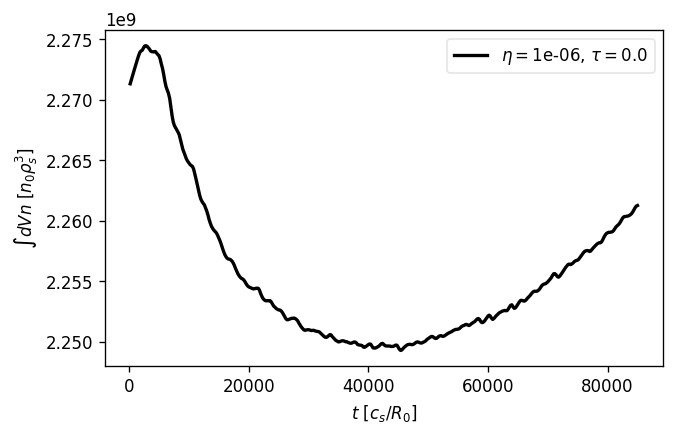

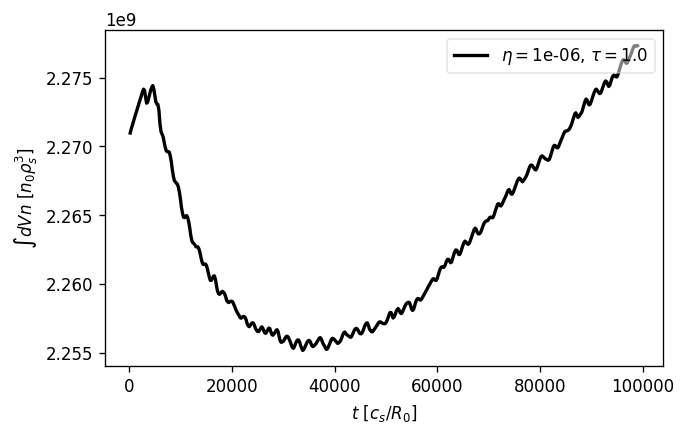

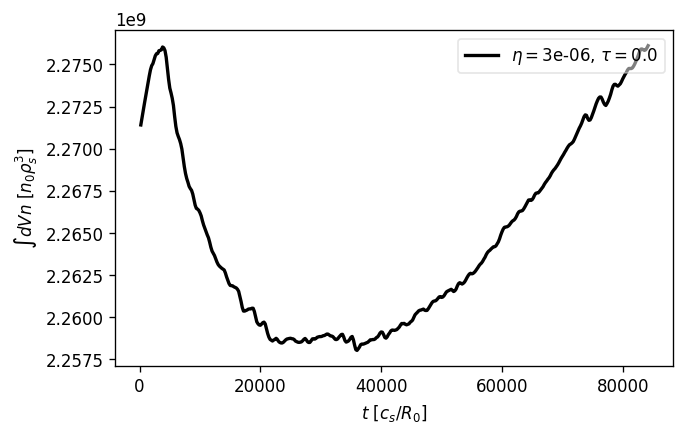

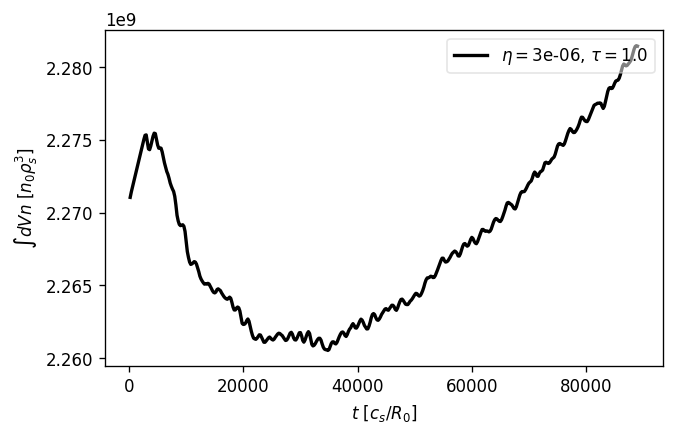

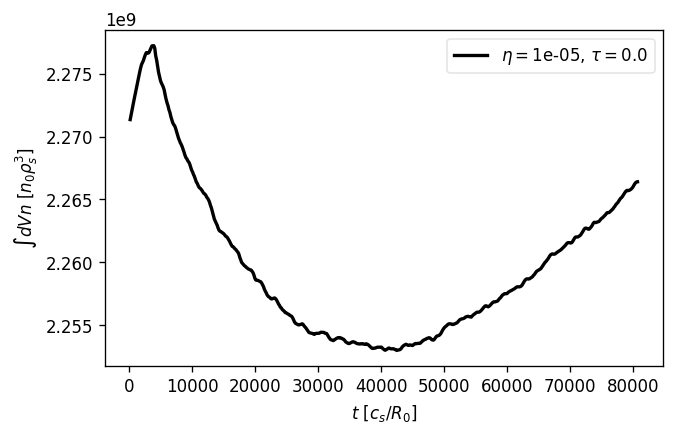

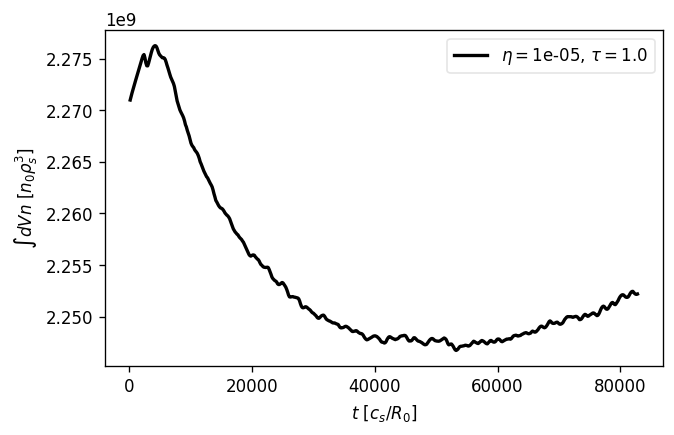

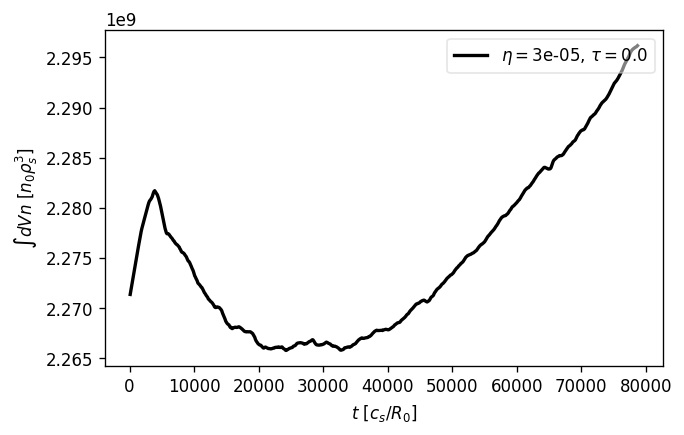

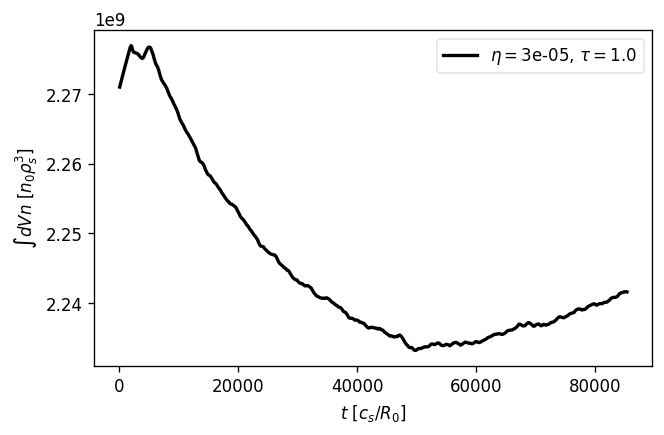

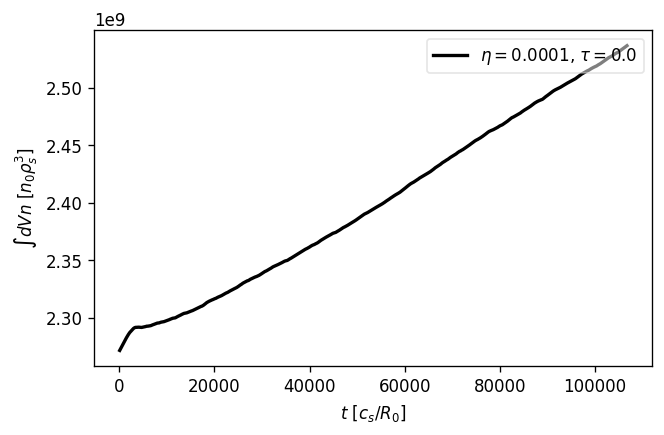

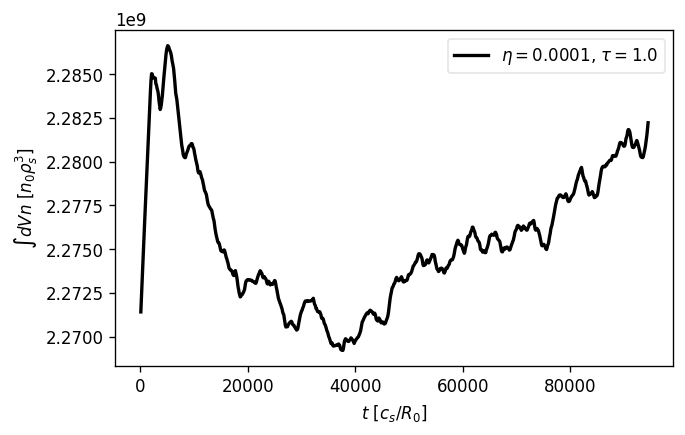

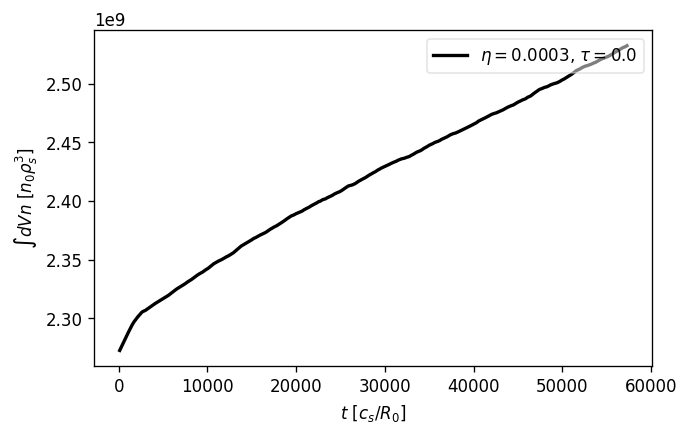

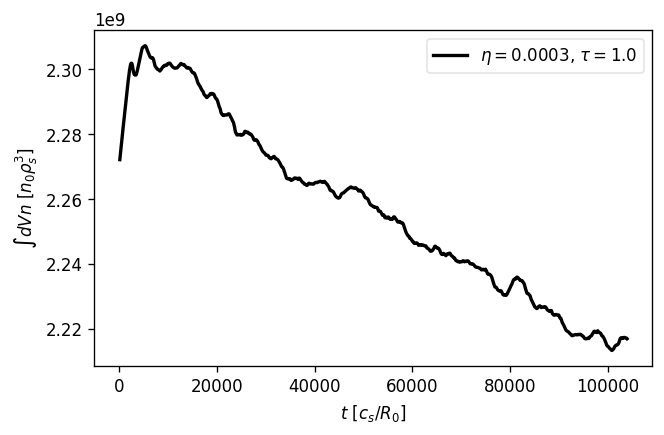

In [15]:
### PLOT OF TOTAL MASS CONTAINED WITHIN SEPARATRIX
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
    time = np.asarray(da['time'][:])
    
#     print( pp["physical"])
#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
    timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])

    plt.plot(time[1:]*timescale,mass[1:], color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}'
            )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\int dV n\ [n_0\rho_s^3]$")

    plt.show(   )

Average flux is 3.60e-04 pm 7.63e-05
Total average mass loss rate is 1786.2
Total mass gain by sources is 2096.9
particle confinement time = 2.07e+01


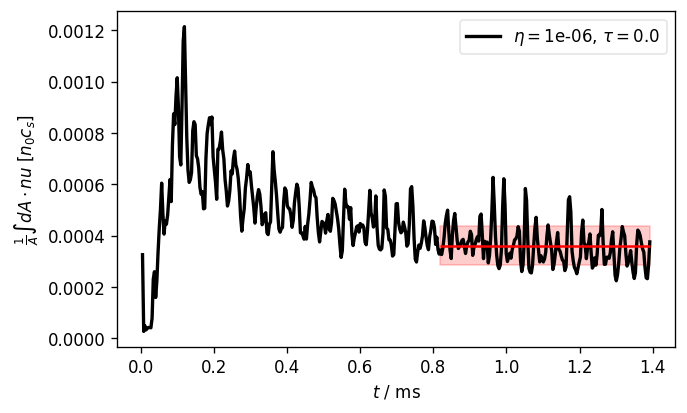

Average flux is 3.37e-04 pm 1.31e-04
Total average mass loss rate is 1670.7
Total mass gain by sources is 2096.9
particle confinement time = 2.22e+01


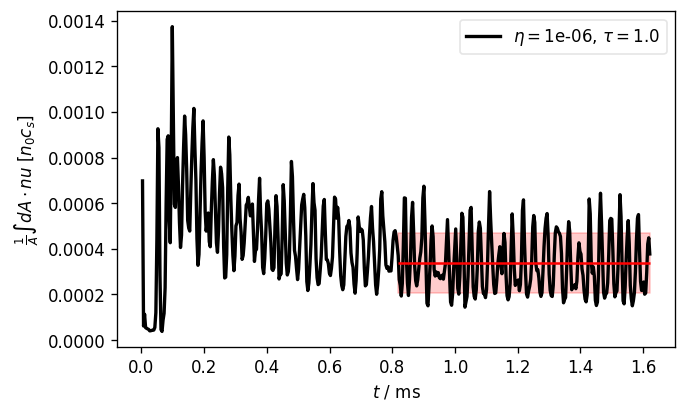

Average flux is 4.21e-04 pm 8.05e-05
Total average mass loss rate is 2086.8
Total mass gain by sources is 2516.2
particle confinement time = 2.34e+01


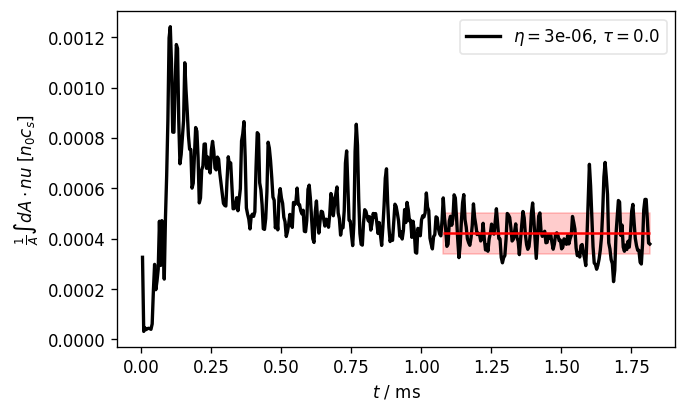

Average flux is 4.17e-04 pm 1.29e-04
Total average mass loss rate is 2069.6
Total mass gain by sources is 2516.2
particle confinement time = 2.37e+01


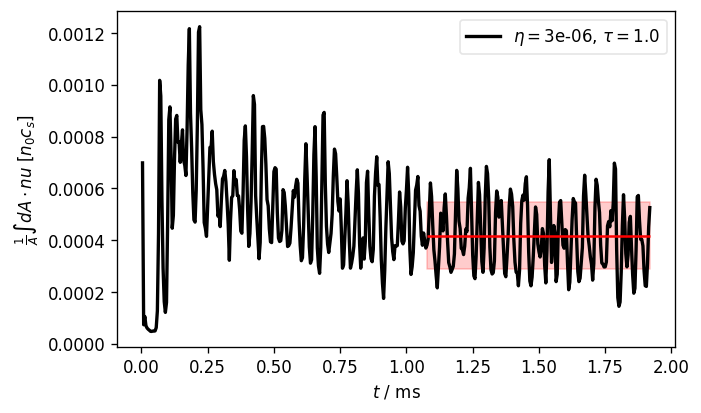

Average flux is 5.25e-04 pm 6.41e-05
Total average mass loss rate is 2600.6
Total mass gain by sources is 2935.6
particle confinement time = 2.53e+01


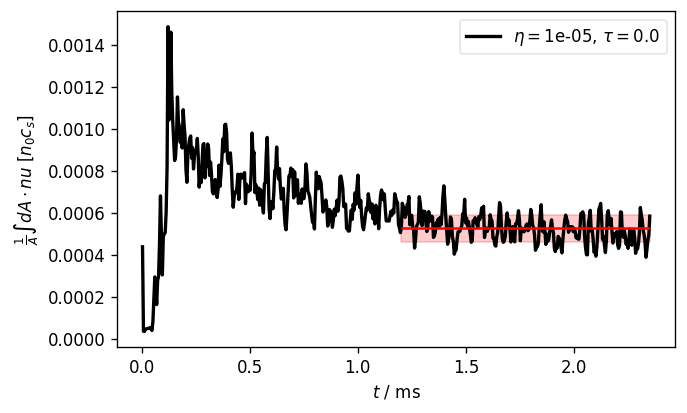

Average flux is 5.70e-04 pm 1.08e-04
Total average mass loss rate is 2825.2
Total mass gain by sources is 2935.6
particle confinement time = 2.32e+01


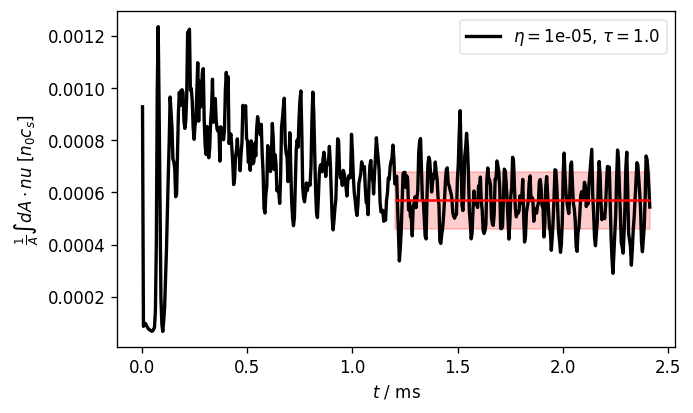

Average flux is 6.90e-04 pm 8.03e-05
Total average mass loss rate is 3420.7
Total mass gain by sources is 4193.7
particle confinement time = 2.56e+01


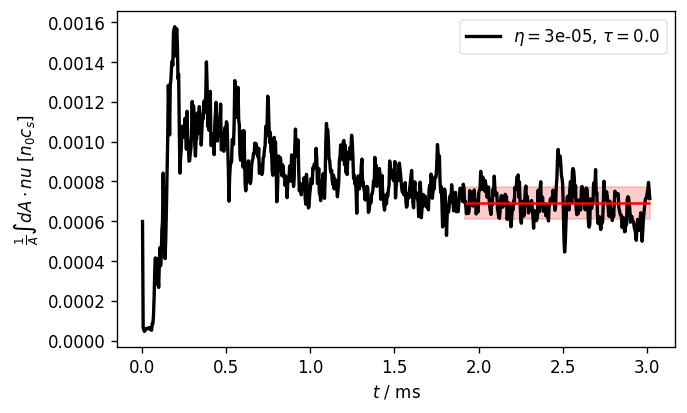

Average flux is 8.03e-04 pm 9.30e-05
Total average mass loss rate is 3979.1
Total mass gain by sources is 4193.7
particle confinement time = 2.16e+01


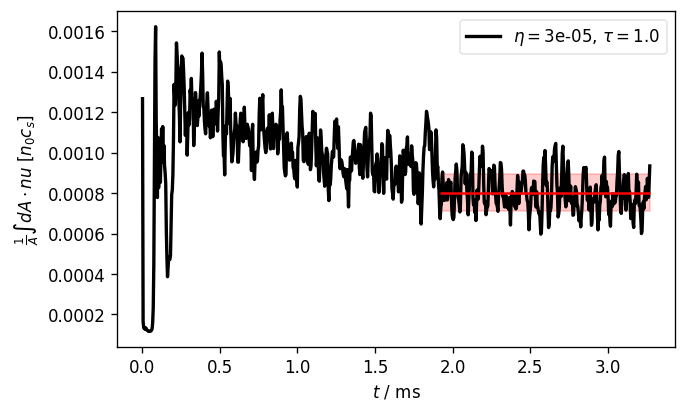

Average flux is 1.19e-03 pm 1.11e-04
Total average mass loss rate is 5904.9
Total mass gain by sources is 8387.4
particle confinement time = 2.13e+01


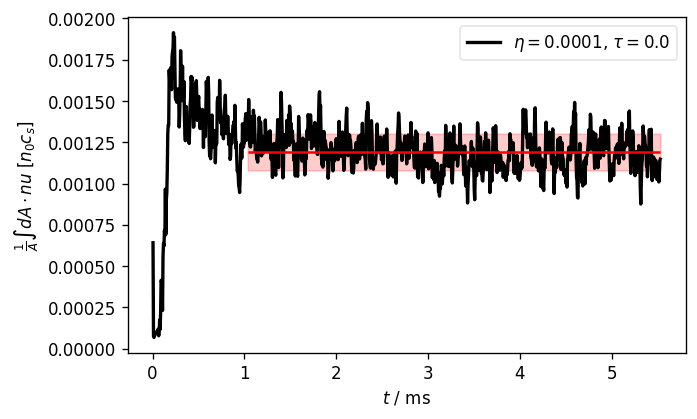

Average flux is 1.69e-03 pm 1.86e-04
Total average mass loss rate is 8357.6
Total mass gain by sources is 8387.4
particle confinement time = 1.41e+01


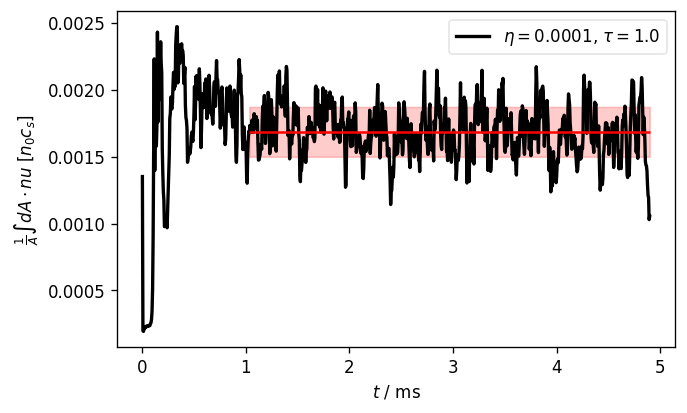

Average flux is 2.65e-03 pm 1.96e-04
Total average mass loss rate is 13121.9
Total mass gain by sources is 16774.8
particle confinement time = 1.27e+01


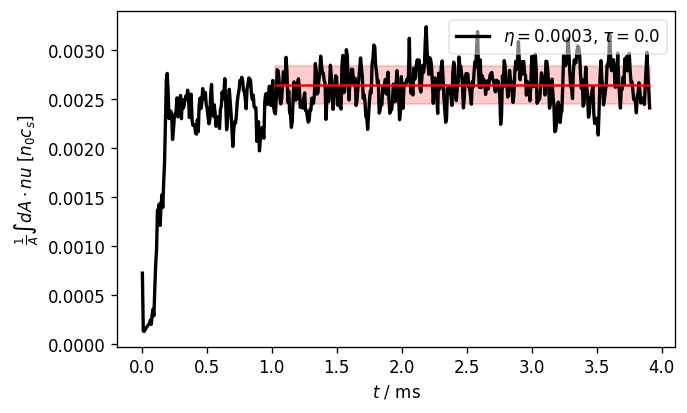

Average flux is 3.60e-03 pm 3.95e-04
Total average mass loss rate is 17844.7
Total mass gain by sources is 16774.8
particle confinement time = 8.60e+00


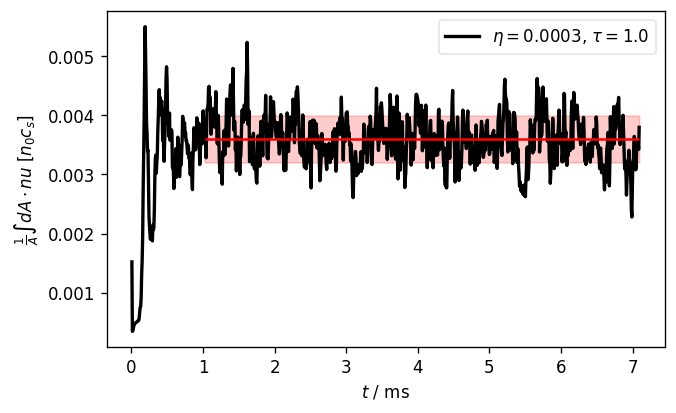

In [16]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')

    da = pp['file']

#     with open( "test-file.json","w") as f:
#         f.write(da.inputfile)
    
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne=np.asarray(da['jvneC_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneE_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneA_tt_ifs_lcfs'][:])/deltat
    divjvne = np.asarray(da["divjnepar_tt_ifs_lcfs"][:])/deltat
    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    #### Fill in parameters list #####
    pp['physical']['average_mass_flux_lcfs'] = average_jvne
    pp['physical']['average_mass_ifs'] = average_mass
    pp['physical']['sigma_mass_flux_lcfs'] = sigma_jvne
    pp['physical']['sigma_mass_ifs'] = sigma_mass
    ###################################
    source = np.asarray(da["sne_tt_ifs_lcfs"][:])/deltat
    average_source = source[min_idx:].mean()
    area = pp['area'][pp['lcfs']]
    print( f"Average flux is { average_jvne/area:1.2e} pm {sigma_jvne/area:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    tau = mass/jvne
    indices = range(min_idx,np.size(time))
    plt.plot(time[1:]*timescale,jvne[1:]/area, color='k', 
#     plt.plot(indices,jvne[min_idx:]/area, color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}'
            )
    plt.hlines(average_jvne/area,
               time[min_idx]*timescale, time[-1]*timescale, color='r')
    plt.fill_between( time[min_idx:]*timescale, (average_jvne-sigma_jvne)/area, 
                      (average_jvne+sigma_jvne)/area, color='red', alpha=0.2)
#     plt.hlines(indices, time[0]*timescale, time[len(time)-1]*timescale, color='k')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ /\ $ms")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    if pp['physical']['tau'] == 1 and pp['physical']['resistivity'] == 1e-4:
        plt.savefig( 'mass-flux.png',bbox_inches='tight')
    plt.show(   )


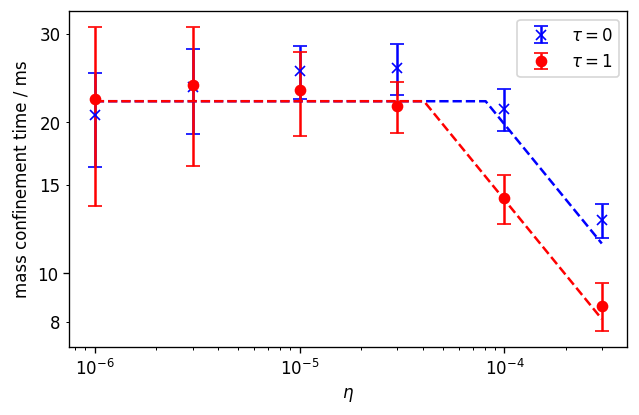

In [17]:
resistivities = {0: [], 1: []}
confinement_times = {0: [], 1: []}
confinement_errs = {0: [], 1: []}
models = {0: [], 1: []}
for pp in content:
    phys= pp['physical']
    resistivities[phys['tau']].append(phys['resistivity'])
    timescale = fp.omega_0_inv(**phys)*1e3 # ms
#     timescale = 1./545.# in cs/R_0
    confinement_times[phys['tau']].append(
        phys['average_mass_ifs']/phys['average_mass_flux_lcfs']*timescale)
 
    confinement_errs[phys['tau']].append(
        np.sqrt((phys['sigma_mass_ifs']/phys['average_mass_flux_lcfs'])**2 + 
                (phys['average_mass_ifs']/phys['average_mass_flux_lcfs']**2*phys['sigma_mass_flux_lcfs'])**2)*
                timescale)
lin_res = np.arange( 1e-6, 3e-4, 1e-6)
for res in lin_res:
    if res > 2*4e-5: 
        models[0].append(
            np.sqrt(2)*0.0014*(1e-4*res)**(-0.5)
        )
    else:
        models[0].append(22)
    if res > 4e-5: 
        models[1].append(
            0.0014*(1e-4*res)**(-0.5)
        )
    else:
        models[1].append(22)
##########################
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# Plot error bar 
# label axes
ax.errorbar( resistivities[0], confinement_times[0],
             yerr=confinement_errs[0], marker='x', ls='',label=r'$\tau=0$',
            color = 'b',capsize=4)
ax.errorbar( resistivities[1], confinement_times[1],
             yerr=confinement_errs[1], marker='o', ls='',label=r'$\tau=1$',
            color = 'r',capsize=4)
ax.plot( lin_res, models[0], ls='--', color = 'b')
ax.plot( lin_res, models[1], ls='--', color = 'r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel('mass confinement time / ms')
# Rewrite the y labels
ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_minor_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.set_yticks( [8, 15, 20,30], minor = True)

plt.legend()
plt.savefig('mass_confinement_time.png',bbox_inches='tight')
plt.show()

## Energy conservation

Average flux is 1.92e-04 pm 3.70e-05
Total average energy loss rate is  952.9
Total energy gain by sources is 6722.1
Energy confinement time = 6.69e+01


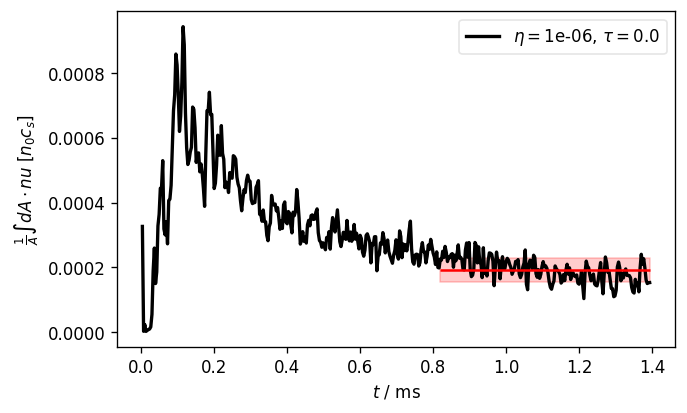

Average flux is 2.62e-04 pm 8.36e-05
Total average energy loss rate is 1299.2
Total energy gain by sources is 13463.4
Energy confinement time = 9.90e+01


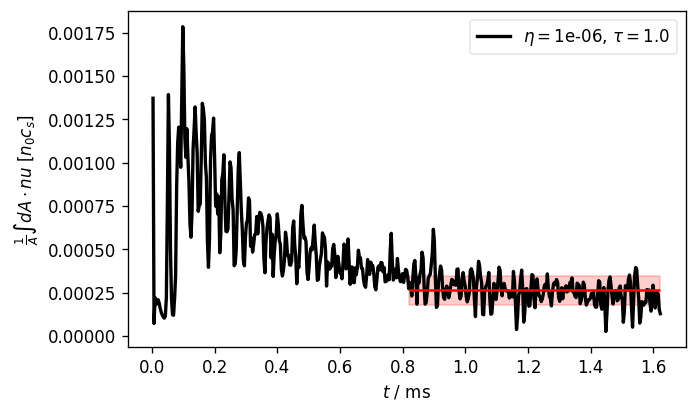

Average flux is 2.48e-04 pm 3.36e-05
Total average energy loss rate is 1229.9
Total energy gain by sources is 8118.5
Energy confinement time = 6.89e+01


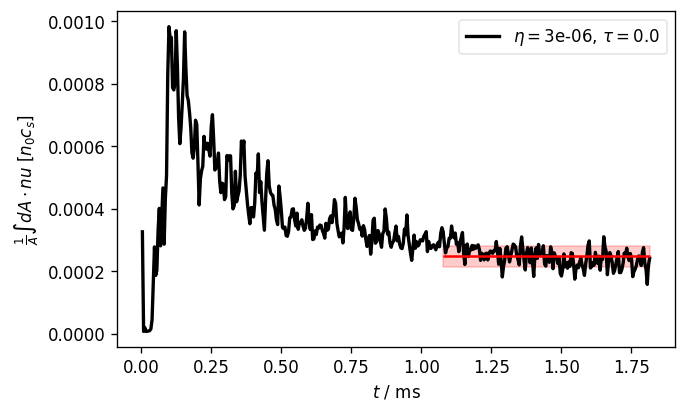

Average flux is 4.01e-04 pm 9.82e-05
Total average energy loss rate is 1988.1
Total energy gain by sources is 16237.1
Energy confinement time = 8.54e+01


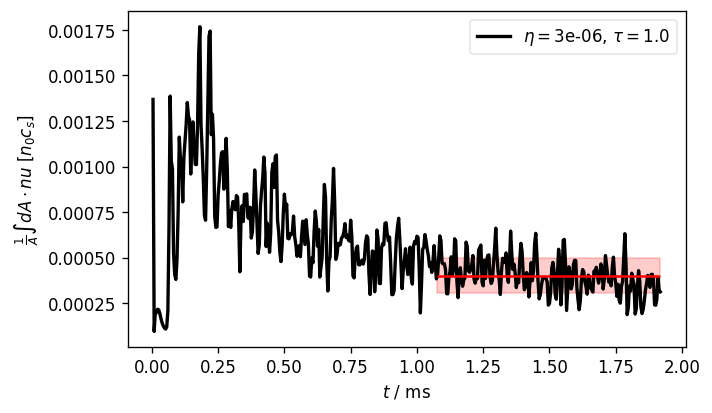

Average flux is 3.48e-04 pm 4.71e-05
Total average energy loss rate is 1724.9
Total energy gain by sources is 9473.3
Energy confinement time = 6.58e+01


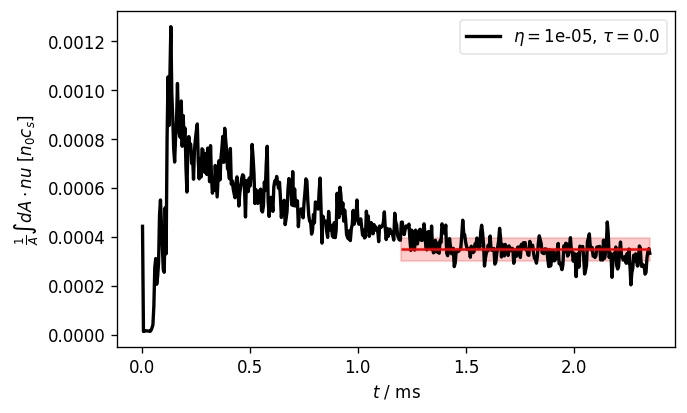

Average flux is 7.20e-04 pm 1.40e-04
Total average energy loss rate is 3567.8
Total energy gain by sources is 18885.4
Energy confinement time = 6.31e+01


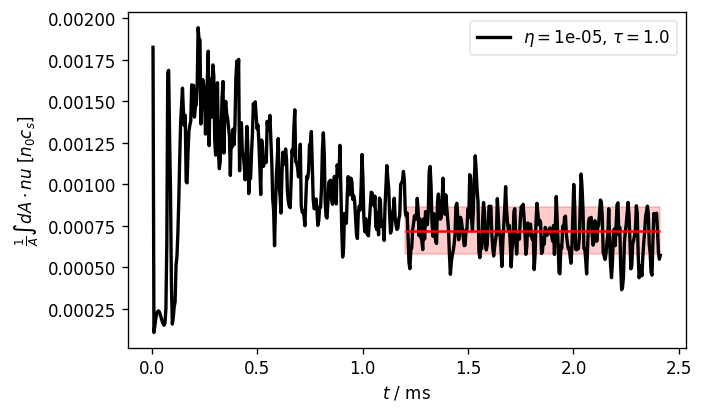

Average flux is 4.68e-04 pm 5.93e-05
Total average energy loss rate is 2319.9
Total energy gain by sources is 13698.1
Energy confinement time = 6.60e+01


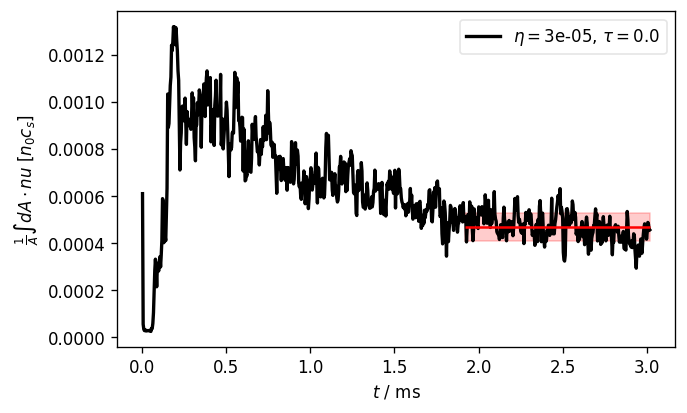

Average flux is 1.10e-03 pm 1.51e-04
Total average energy loss rate is 5468.0
Total energy gain by sources is 27153.9
Energy confinement time = 5.41e+01


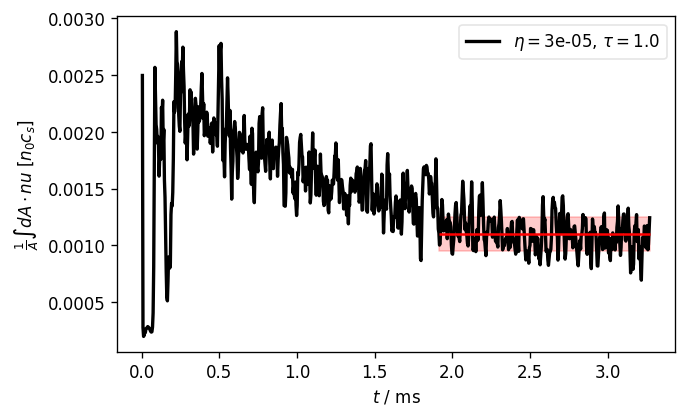

Average flux is 1.07e-03 pm 1.11e-04
Total average energy loss rate is 5312.4
Total energy gain by sources is 27629.8
Energy confinement time = 4.23e+01


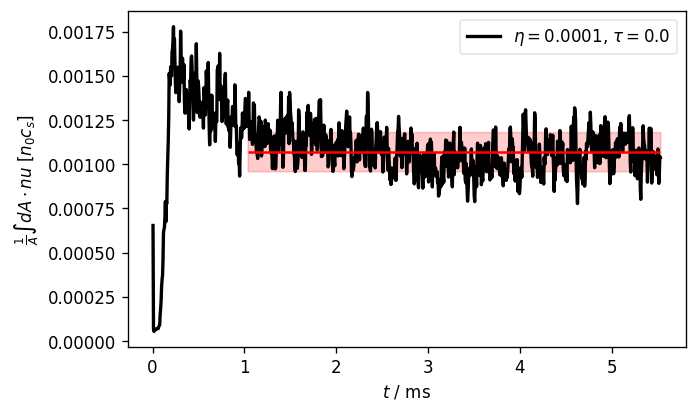

Average flux is 3.35e-03 pm 3.99e-04
Total average energy loss rate is 16600.8
Total energy gain by sources is 53547.0
Energy confinement time = 2.42e+01


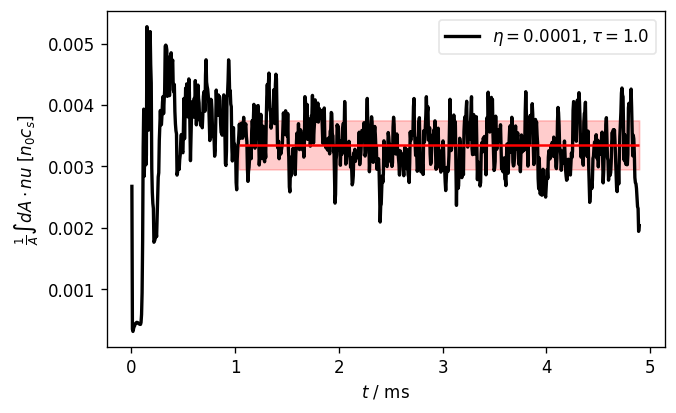

Average flux is 3.38e-03 pm 2.85e-04
Total average energy loss rate is 16752.6
Total energy gain by sources is 54135.7
Energy confinement time = 1.74e+01


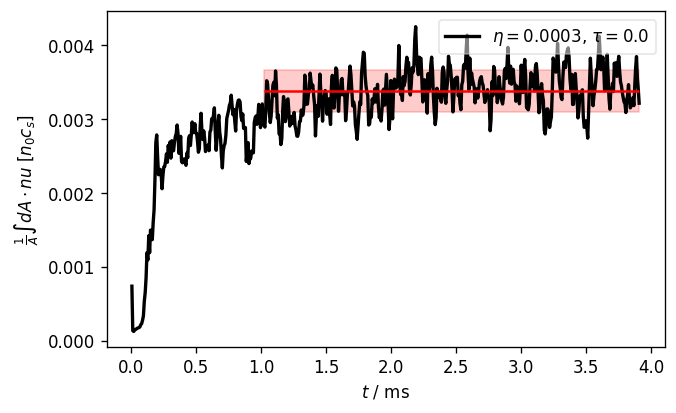

Average flux is 1.00e-02 pm 1.16e-03
Total average energy loss rate is 49613.1
Total energy gain by sources is 103869.1
Energy confinement time = 1.02e+01


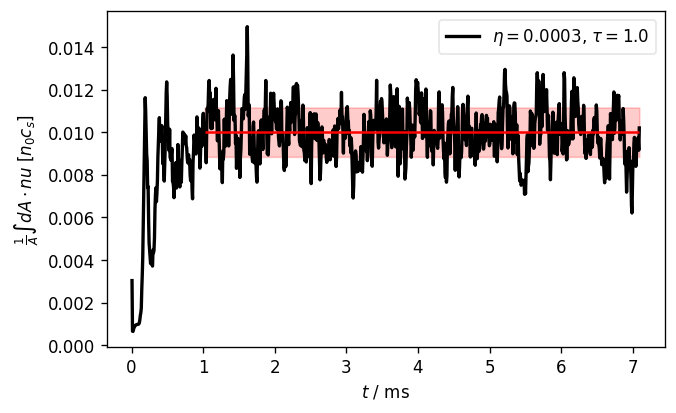

In [18]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    
    da = pp['file']
 
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)

    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]

#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['ue2_ifs_lcfs'][:])
    mass+=np.asarray(da['nelnne_ifs_lcfs'][:])
    mass+=np.asarray(da['nilnni_ifs_lcfs'][:])
    mass+=np.asarray(da['neue2_ifs_lcfs'][:])
    mass+=np.asarray(da['niui2_ifs_lcfs'][:])
    mass+=np.asarray(da['aperp2_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne = da.variables['jvee_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jvei_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveea_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveia_tt_ifs_lcfs'][:]/deltat
    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    #### Fill in parameters list #####
    pp['physical']['average_energy_flux_lcfs'] = average_jvne
    pp['physical']['average_energy_ifs'] = average_mass
    pp['physical']['sigma_energy_flux_lcfs'] = sigma_jvne
    pp['physical']['sigma_energy_ifs'] = sigma_mass
    ###################################
    source =da.variables['see_tt_ifs_lcfs'][:]/deltat
    source+=da.variables['sei_tt_ifs_lcfs'][:]/deltat
    average_source = source[min_idx:].mean()
    area = pp['area'][pp['lcfs']]
    print( f"Average flux is { average_jvne/area:1.2e} pm {sigma_jvne/area:1.2e}")
    print( f"Total average energy loss rate is {average_jvne:6.1f}")
    print( f"Total energy gain by sources is {average_source:6.1f}" )
    print( f"Energy confinement time = {average_mass/average_jvne*timescale:1.2e}")
    tau = mass/jvne

    plt.plot(time[1:]*timescale,jvne[1:]/area, color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}')
    plt.hlines(average_jvne/area, time[min_idx]*timescale, time[-1]*timescale, color='r')
    plt.fill_between( time[min_idx:]*timescale, (average_jvne-sigma_jvne)/area, 
                      (average_jvne+sigma_jvne)/area, color='red', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ /\ $ms")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    if pp['physical']['tau'] == 1 and pp['physical']['resistivity'] == 1e-4:
        plt.savefig( 'energy-flux.png',bbox_inches='tight')
    plt.show(   )


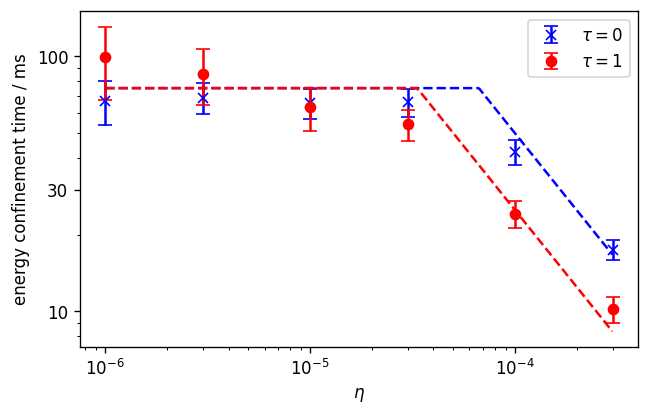

In [19]:
resistivities = {0: [], 1: []}
confinement_times = {0: [], 1: []}
confinement_errs = {0: [], 1: []}

for pp in content:
    phys= pp['physical']
    resistivities[phys['tau']].append(phys['resistivity'])
    timescale = fp.omega_0_inv(**phys)*1e3 # ms
#     timescale = 1./545.# in cs/R_0
    confinement_times[phys['tau']].append(
        phys['average_energy_ifs']/phys['average_energy_flux_lcfs']*timescale)
 
    confinement_errs[phys['tau']].append(
        np.sqrt((phys['sigma_energy_ifs']/phys['average_energy_flux_lcfs'])**2 + 
                (phys['average_energy_ifs']/phys['average_energy_flux_lcfs']**2*phys['sigma_energy_flux_lcfs'])**2)*
                timescale)
models = {0: [], 1: []}
lin_res = np.arange( 1e-6, 3e-4, 1e-6)
for res in lin_res:
    if res > 2*3.3e-5: 
        models[0].append(
            2*2.5e-7*(1e-4*res)**(-1)
        )
    else:
        models[0].append(75)
    if res > 3.3e-5: 
        models[1].append(
            2.5e-7*(1e-4*res)**(-1)
        )
    else:
        models[1].append(75)

##########################
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# Plot error bar 
# label axes
ax.errorbar( resistivities[0], confinement_times[0],
             yerr=confinement_errs[0], marker='x', ls='',label=r'$\tau=0$',
            color = 'b',capsize=4)
ax.errorbar( resistivities[1], confinement_times[1],
             yerr=confinement_errs[1], marker='o', ls='',label=r'$\tau=1$',
            color = 'r',capsize=4)
ax.plot( lin_res, models[0], ls='--', color = 'b')
ax.plot( lin_res, models[1], ls='--', color = 'r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel('energy confinement time / ms')
# Rewrite the y labels
ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.0f}'))
# ax.yaxis.set_minor_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.set_yticks( [10,30,100])

plt.legend()
plt.savefig('energy_confinement_time.png',bbox_inches='tight')
plt.show()

Let's be careful with too general conclusions about the two regimes. The equations are fairly basic with isothermal assumption. There could still be hidden systematic numerical issues (e.g. turbulence in low resistivity does not reach core region?)

### Average FSA Mass conservation 

Resistivity = 1e-06 tau = 0.0
Average diff =  -93.98890454446816
Average std  =  25.098444068014178


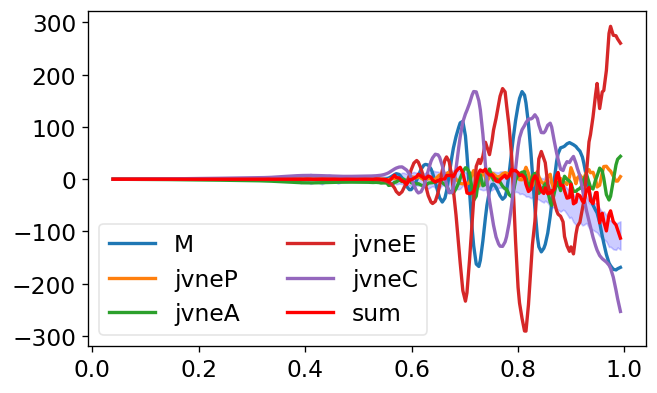

Resistivity = 1e-06 tau = 1.0
Average diff =  -12.191441250265699
Average std  =  30.796534891787545


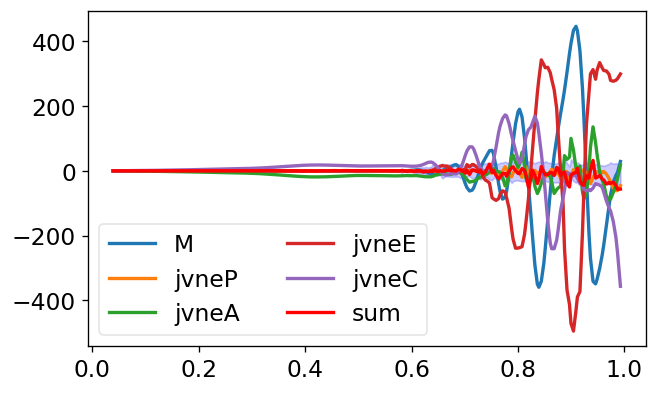

Resistivity = 3e-06 tau = 0.0
Average diff =  -97.94016827088727
Average std  =  23.35208553629891


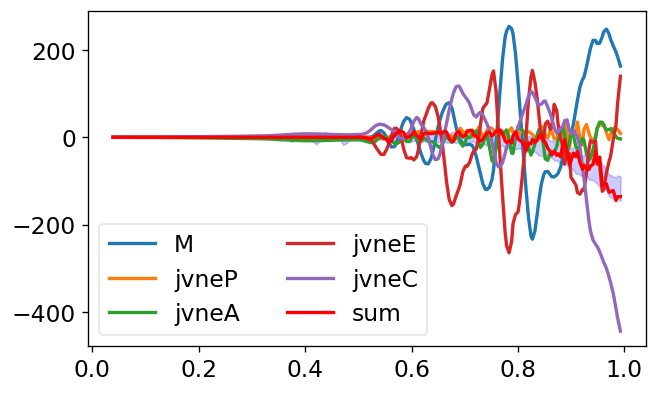

Resistivity = 3e-06 tau = 1.0
Average diff =  -17.328113074807423
Average std  =  27.12994458784164


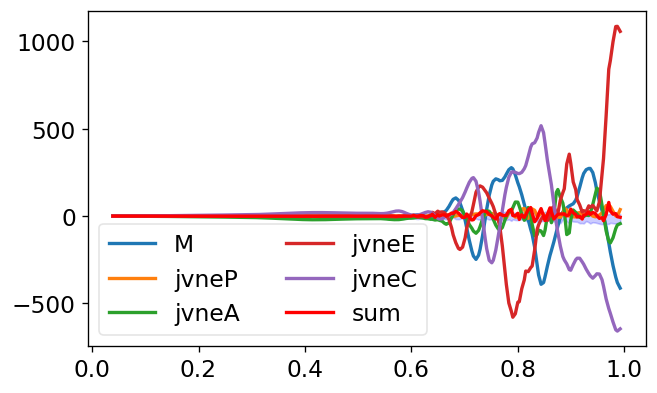

Resistivity = 1e-05 tau = 0.0
Average diff =  -101.68065292514567
Average std  =  24.373666329388936


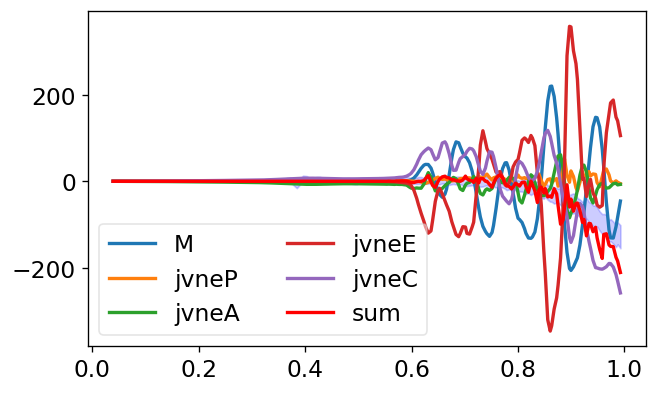

Resistivity = 1e-05 tau = 1.0
Average diff =  -10.440912536831062
Average std  =  24.64741129374549


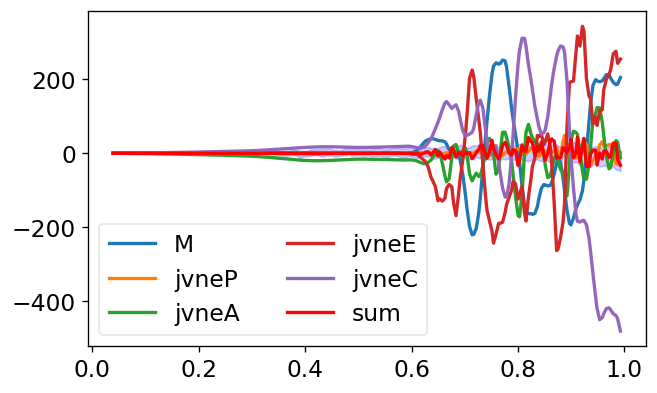

Resistivity = 3e-05 tau = 0.0
Average diff =  -120.98226352590248
Average std  =  26.96526998457242


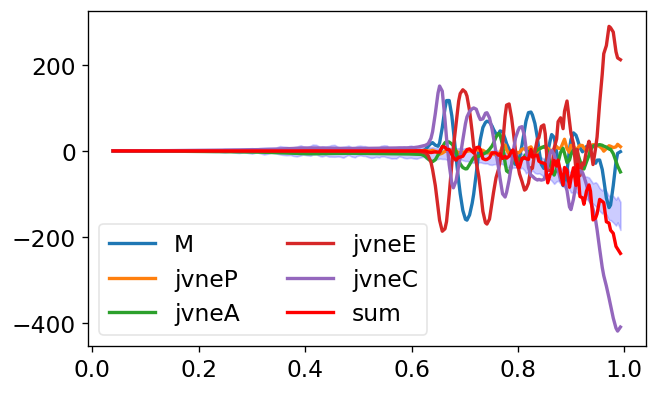

Resistivity = 3e-05 tau = 1.0
Average diff =  -15.635399313719155
Average std  =  31.36322925965401


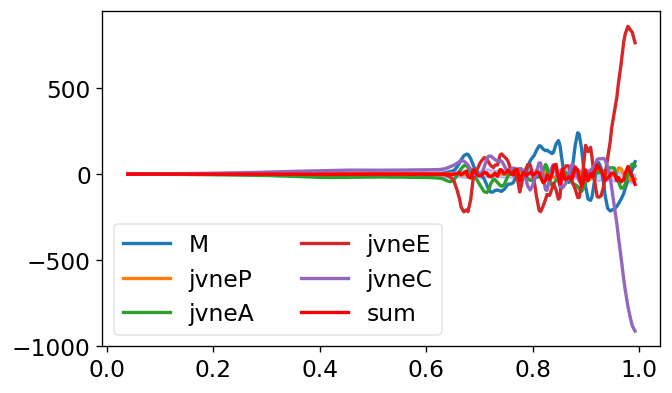

Resistivity = 0.0001 tau = 0.0
Average diff =  -145.18095691356476
Average std  =  49.42643434101611


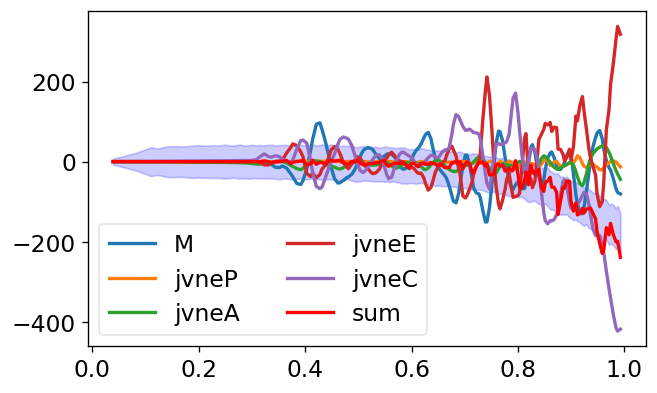

Resistivity = 0.0001 tau = 1.0
Average diff =  25.013795019243044
Average std  =  55.70705776839116


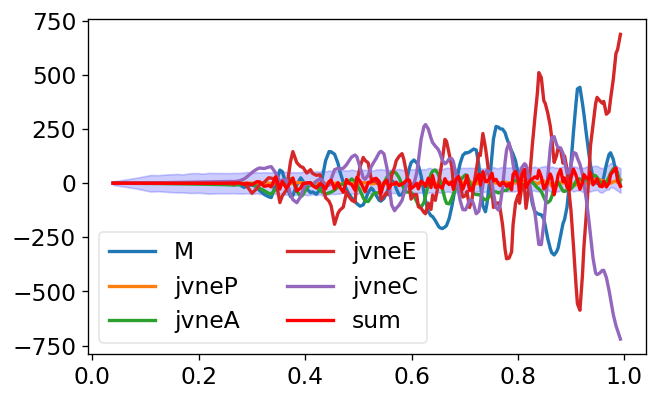

Resistivity = 0.0003 tau = 0.0
Average diff =  -117.12694839713805
Average std  =  118.67920780240706


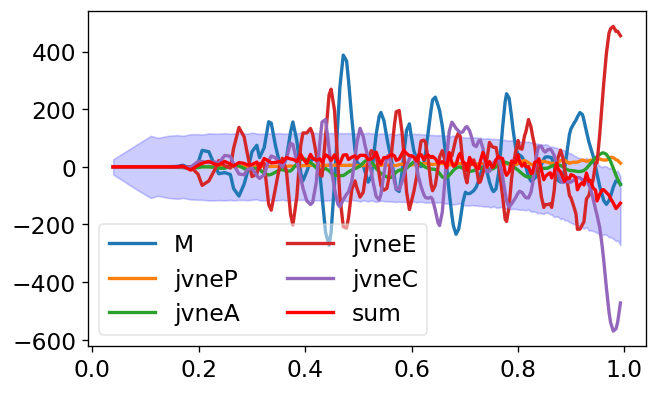

Resistivity = 0.0003 tau = 1.0
Average diff =  135.54003365580562
Average std  =  151.9015703572301


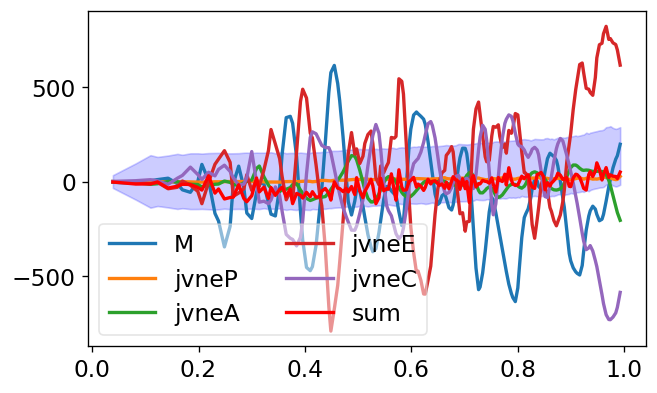

In [52]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']

    mass =np.asarray(da['electrons_ifs'][:,:]-da['ions_ifs'][:,:])
    time = np.asarray(da['time'][:])
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(pp['rho']))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    jvneC=np.asarray(da['jvneC_tt_fsa'][:,:]-da['jvniC_tt_fsa'][:,:])/deltat[:,None]
    jvneE=np.asarray(da['jvneE_tt_fsa'][:,:]-da['jvniE_tt_fsa'][:,:])/deltat[:,None]
    jvneA=np.asarray(da['jvneA_tt_fsa'][:,:]-da['jvniA_tt_fsa'][:,:])/deltat[:,None]
    jvneP=np.asarray(da['divjnepar_tt_ifs'][:,:]-da['divjnipar_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA+jvneP
    
#     diff_perp = np.asarray(da["lneperp_tt_fsa"][:,:])/deltat[:,None]
#     diff_parallel = np.asarray(da["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne#-diff_perp-diff_parallel
    diff = (deltamass + rhs)
   
    average_diff = np.mean( diff[min_idx:], axis=0)
    average_std =  np.std( diff[min_idx:], axis=0)
    idx=160
    print(f'Resistivity = {pp["physical"]["resistivity"]} tau = {pp["physical"]["tau"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot( pp['rho_t'][0:167], deltamass[100,0:167], ls = '-', lw = 2, label = 'M')
    plt.plot( pp['rho_t'][0:167], jvneP[100,0:167], ls = '-', lw = 2, label = 'jvneP')
    plt.plot( pp['rho_t'][0:167], jvneA[100,0:167], ls = '-', lw = 2, label = 'jvneA')
    plt.plot( pp['rho_t'][0:167], jvneE[100,0:167], ls = '-', lw = 2, label = 'jvneE')
    plt.plot( pp['rho_t'][0:167], jvneC[100,0:167], ls = '-', lw = 2, label = 'jvneC')
    plt.plot( pp['rho_t'][0:167], diff[100,0:167], ls = '-', color='r', lw = 2, label = 'sum')
    plt.fill_between( pp['rho_t'][0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='b', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    plt.show()

### Local Mass conservation on LCFS

Resistivity = 1e-06
Average diff =  0.0005695454685986828
Average std  =  0.007411358385814893
Resistivity = 1e-06
Average diff =  0.00048813485064995503
Average std  =  0.0029034993477745283
Resistivity = 3e-06
Average diff =  0.0009683129366971984
Average std  =  0.00871585588262152
Resistivity = 3e-06
Average diff =  0.00026660788979938975
Average std  =  0.003245914780991717
Resistivity = 1e-05
Average diff =  0.0002757749352229925
Average std  =  0.007233922756958384
Resistivity = 1e-05
Average diff =  0.00021673930517132606
Average std  =  0.0042591632462551385
Resistivity = 3e-05
Average diff =  0.00015799995467706608
Average std  =  0.007531690890609755
Resistivity = 3e-05
Average diff =  0.0006096188723679044
Average std  =  0.004789638894691579
Resistivity = 0.0001
Average diff =  0.00048715796056245445
Average std  =  0.006611582895431765
Resistivity = 0.0001
Average diff =  0.0006537736492296313
Average std  =  0.004497078813274631
Resistivity = 0.0003
Average diff =  0.001

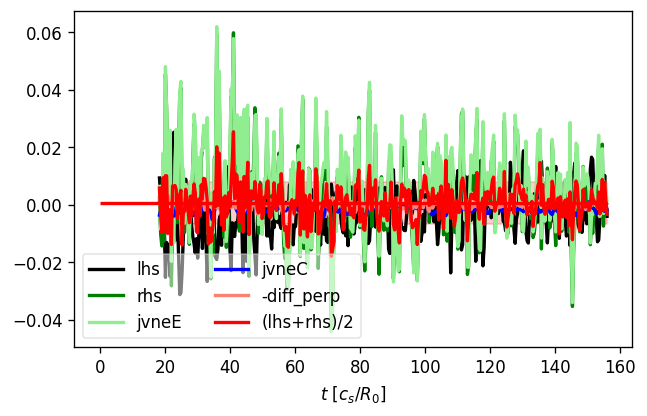

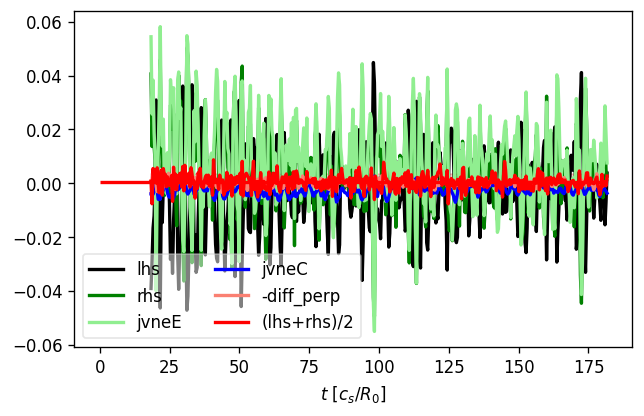

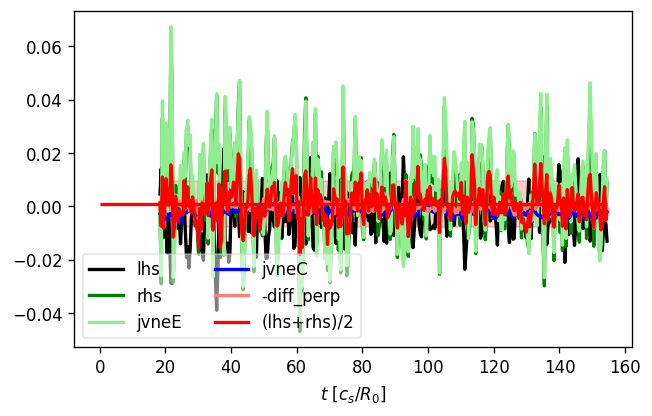

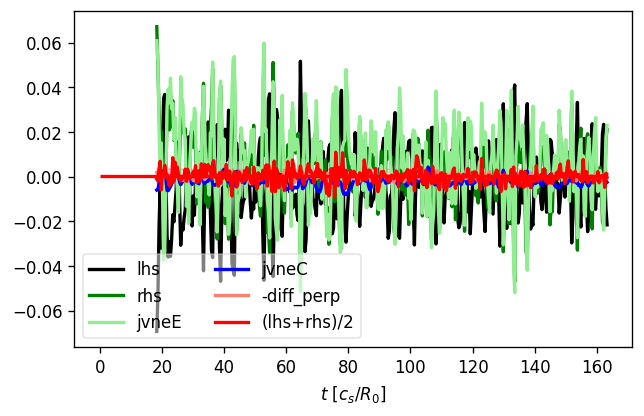

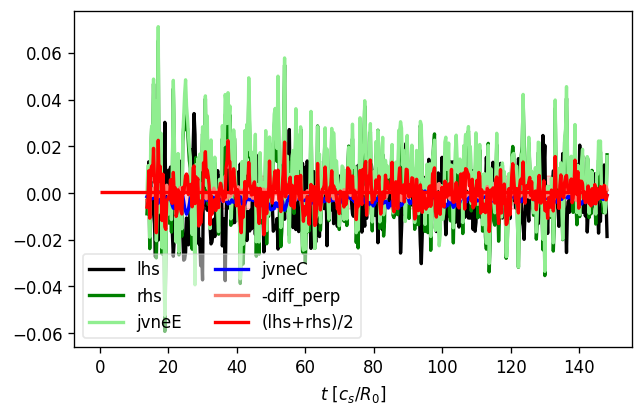

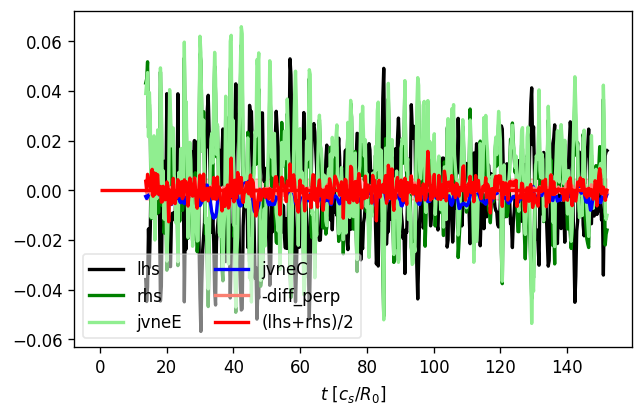

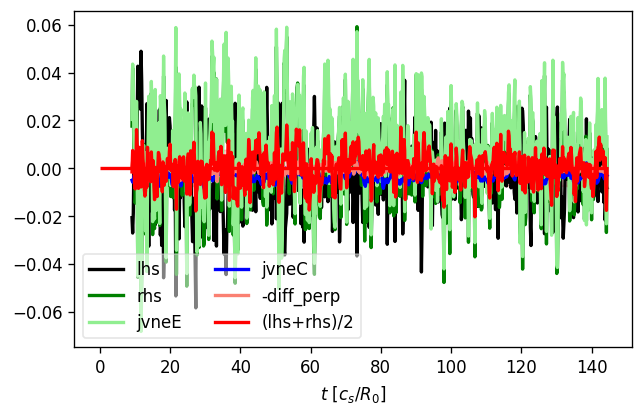

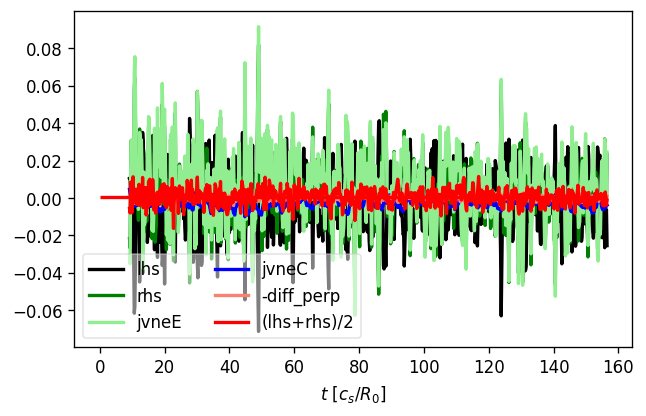

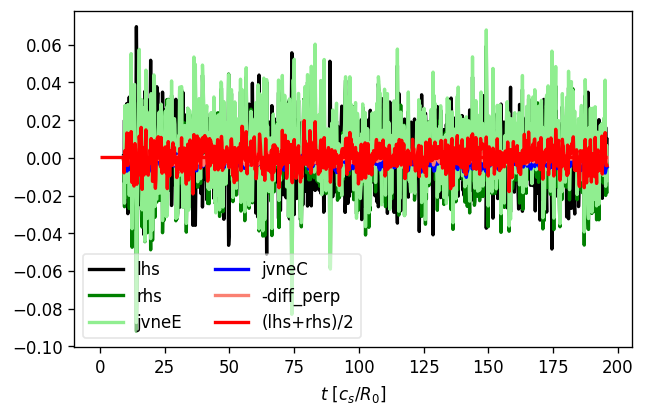

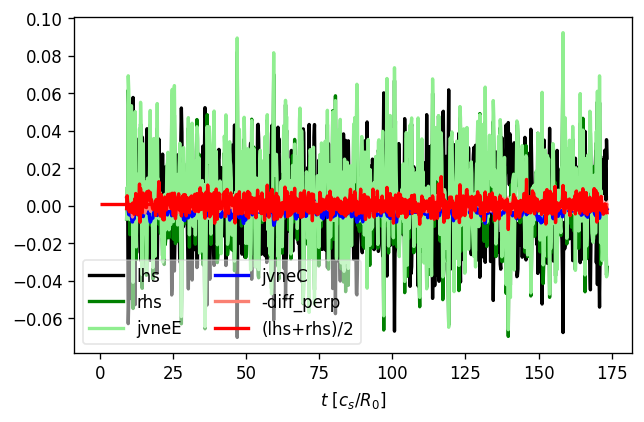

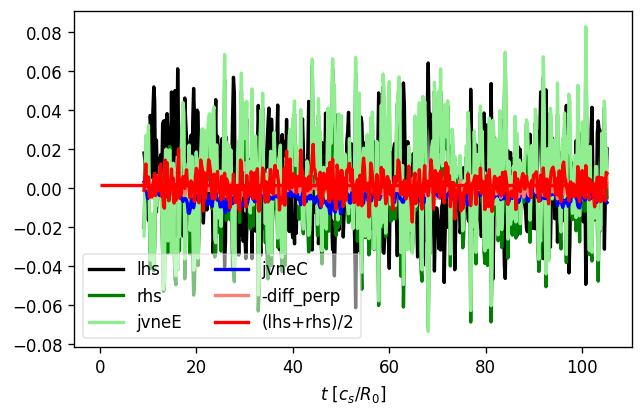

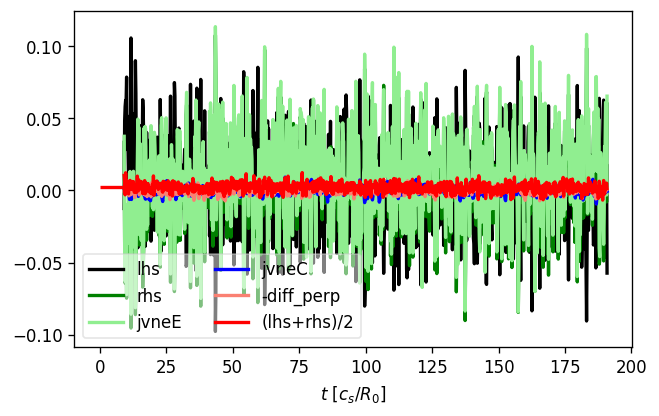

In [21]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']

    mass =np.asarray(da.variables['electrons_fsa'][:,:])

#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    time = np.asarray(da.variables['time'][:])*timescale
    timett = np.append(2*time[-1] -time[-2], time ) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(pp['rho']))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(da.variables['sne_tt_fsa'][:,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(da.variables['jvneC_tt_ifs'][:,:])/deltat[:,None]
    jvneE=np.asarray(da.variables['jvneE_tt_ifs'][:,:])/deltat[:,None]
    jvneA=np.asarray(da.variables['jvneA_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(da.variables["lneperp_tt_fsa"][:,:])/deltat[:,None]
    diff_parallel = np.asarray(da.variables["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne-diff_perp-diff_parallel
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    min_idx = 50
    plt.plot(time[min_idx:],deltamass[min_idx:,idx], color='k', marker='',
              ls='-',lw=2, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g',
              ls='-', lw = 2,  label="rhs")
    plt.plot(time[min_idx:],jvneE[min_idx:,idx], color='lightgreen',
              ls='-', lw = 2, label="jvneE")
    plt.plot(time[min_idx:],jvneC[min_idx:,idx], color='blue',
              ls='-', lw = 2, label="jvneC")
    plt.plot(time[min_idx:],-diff_perp[min_idx:,idx], color='salmon',
              ls='-', lw = 2,  label="-diff_perp")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r',
              ls='-', lw = 2,  label="(lhs+rhs)/2")
    plt.hlines(average_diff[idx], time[0], time[-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    plt.xlabel(r"$t\ [c_s/R_0]$")

### Density profile

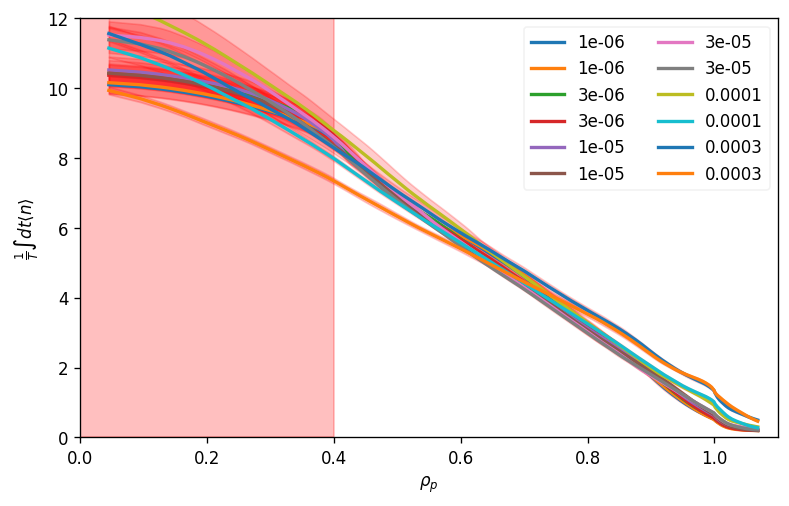

In [22]:

fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
for pp in content :
    da = pp['file']

    time = np.asarray(da.variables['time'][:])
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    density =da.variables['electrons_fsa'][:]
    source = da.variables['sne_tt_fsa'][:]

#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
#     print(f'Resistivity = {pp["physical"]["resistivity"]}')
#     print( "Dataset length ", len(time))
#     print( "Average region ", time[min_idx]*timescale, time[-1]*timescale)
    avg_density=density[min_idx:-1].mean(axis=0)
    std_density=density[min_idx:-1].std(axis=0)
    avg_source = source.mean(axis=0)
    plt.plot( pp['rho_p'], avg_density, ls='-', lw=2, label=f'{pp["physical"]["resistivity"]}')
    # plt.plot( pp['rho_t'], density[-1,:],color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( pp['rho_t'], avg_source*1000,color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( pp['rho_t'],   -psi_p*3+1, ls='--', color = 'k')
#     plt.plot( pp['rho_p'],   -psi_p/2+1, ls='--', color = 'k')
    plt.fill_between( pp['rho_p'], (avg_density-std_density), 
                      (avg_density+std_density), color='red', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.25)
    da.close()
ax.axvspan(0, 0.4, alpha=0.25, color='red')

plt.xlabel(r"$\rho_p$")
# plt.xlabel(r"$\sqrt{\psi_p/\psi_{O}}$")

plt.ylabel(r"$\frac{1}{T}\int dt \langle n\rangle$")
plt.xlim(0.0,1.1)
plt.ylim(0,12)
plt.show(  )

## Ion toroidal momentum plot

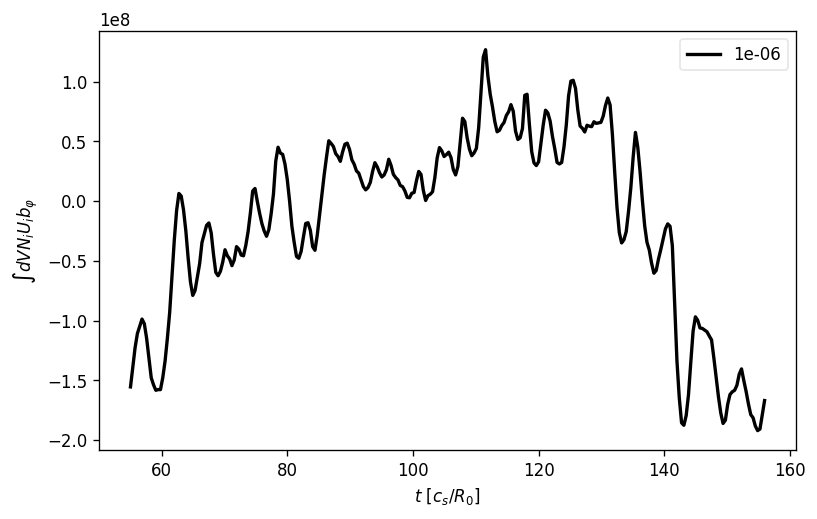

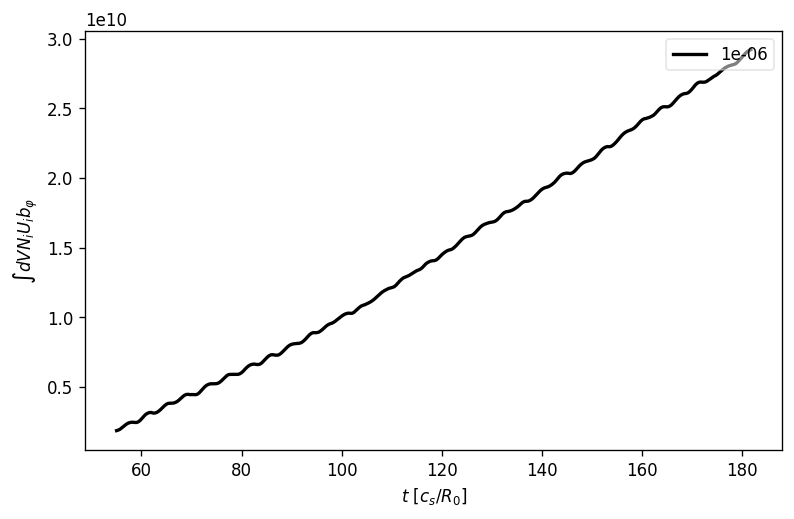

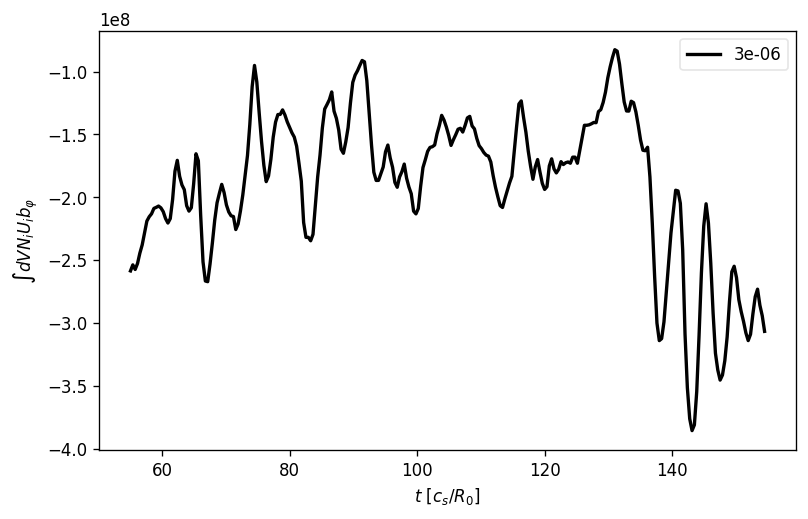

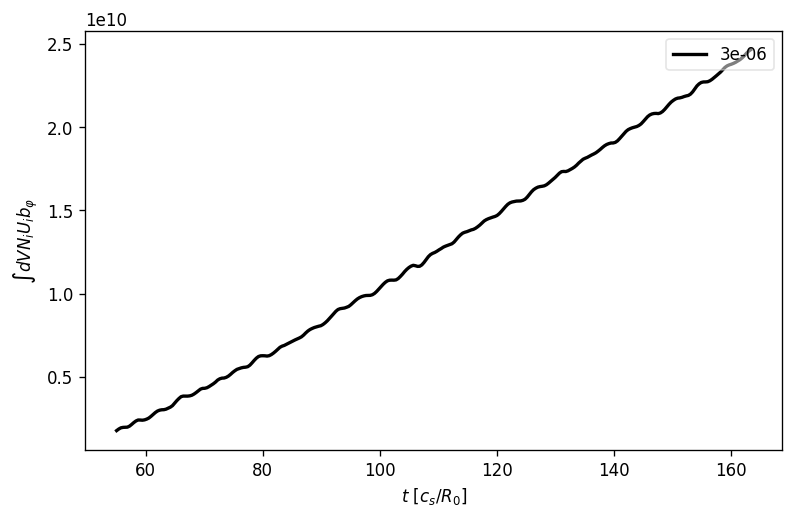

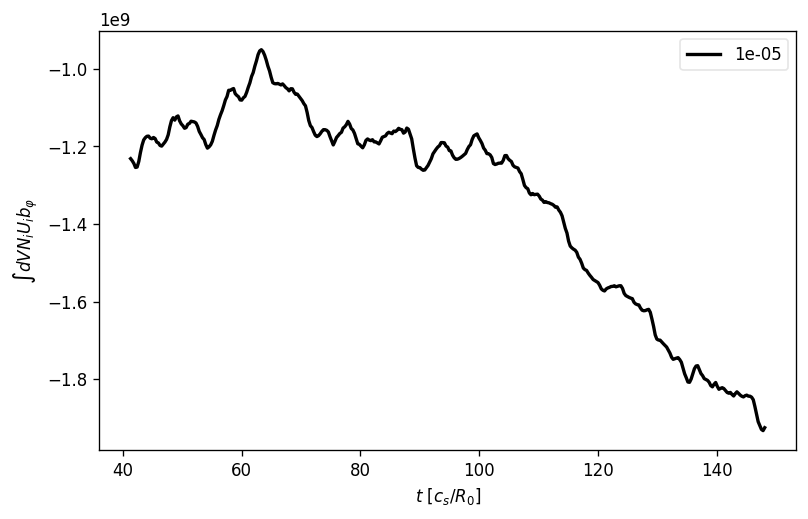

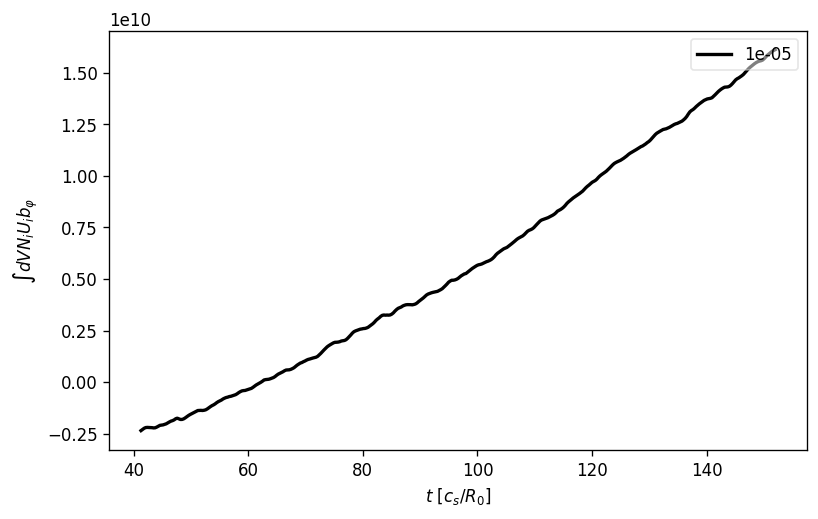

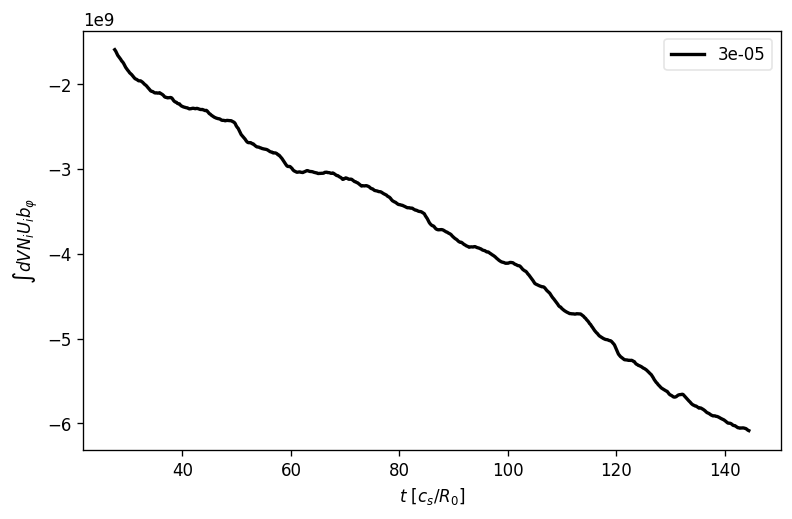

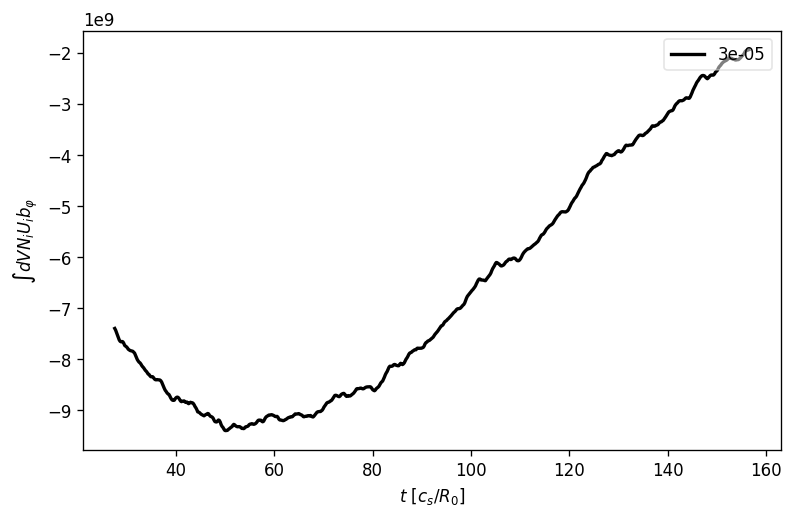

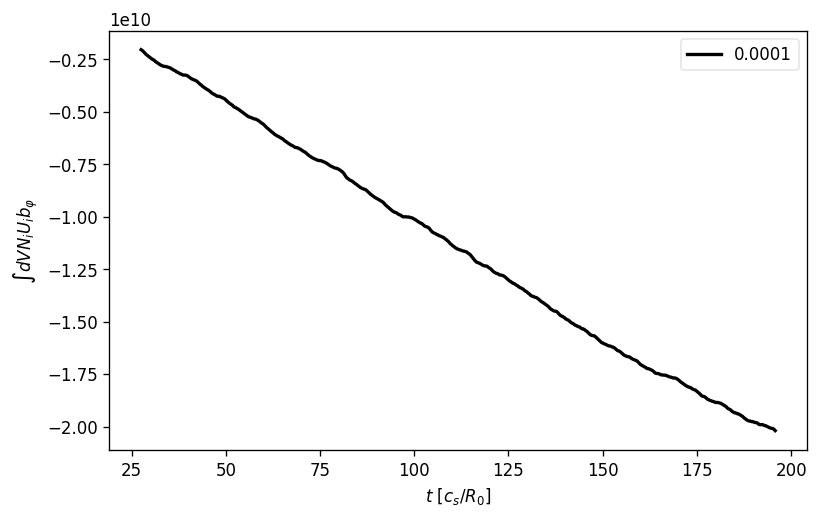

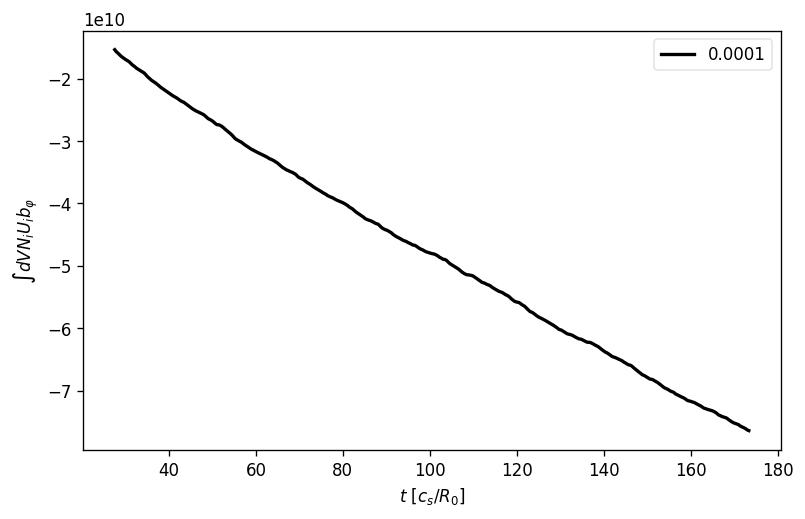

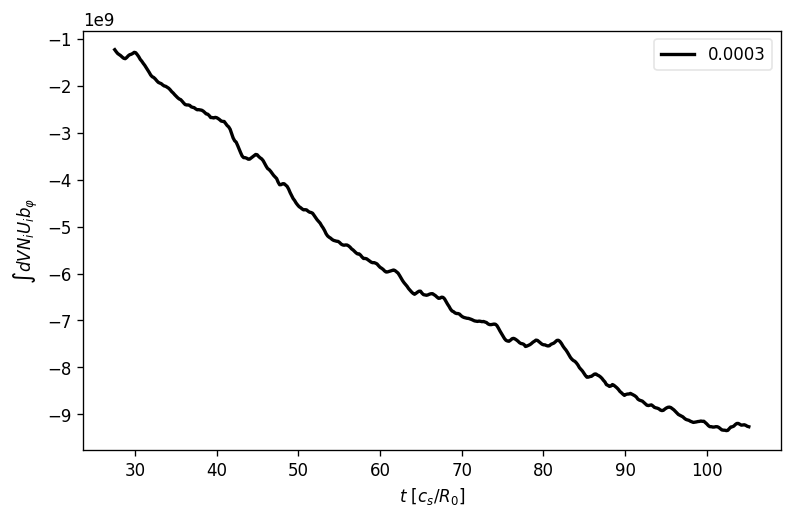

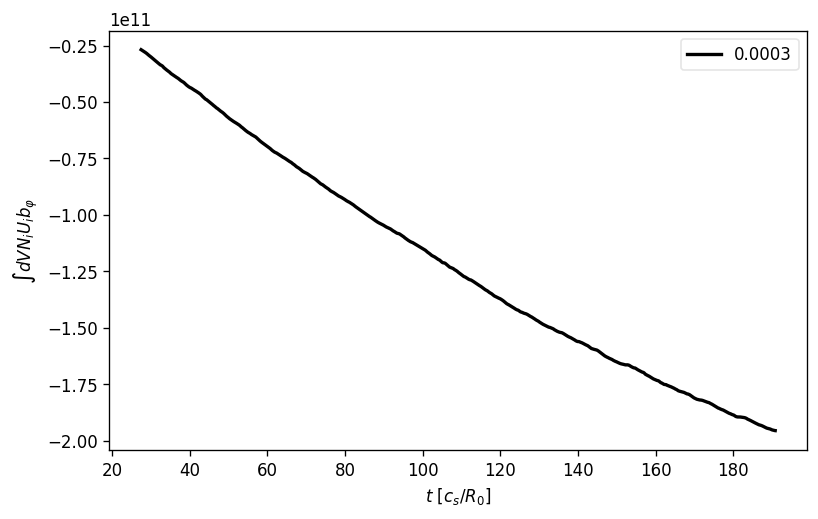

In [23]:
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = da.variables['time'][:]*timescale
    
    niuibphi = da.variables['niuibphi_ifs_lcfs'][:]
    oexb = da.variables['oexbi_ifs_lcfs'][:]

    plt.plot(time[min_idx:],niuibphi[min_idx:], color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=f'{pp["physical"]["resistivity"]}')
#     plt.plot(time[min_idx:],oexb[min_idx:], color='g', 
#          marker='',ls='-', lw=2,markeredgecolor='k', markersize=8
#          )
#     plt.plot(time[min_idx:],niuibphi[min_idx:]-oexb[min_idx:], color='r', 
#          marker='',ls='-', lw=2,markeredgecolor='r', markersize=8
#          )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\int dV  N_iU_ib_\varphi$")

    plt.show(   )

### Ion toroidal momentum accuracy

Resistivity = 1e-06
Average diff =  -114290.66453968856


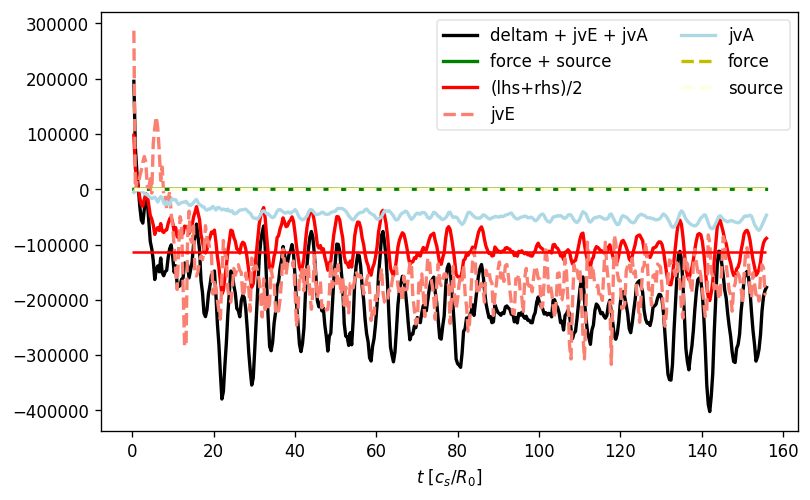

Resistivity = 1e-06
Average diff =  34105.884806517795


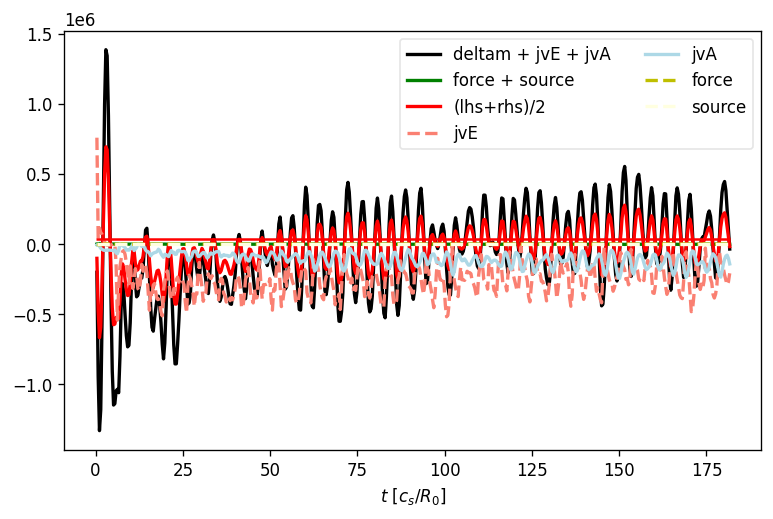

Resistivity = 3e-06
Average diff =  -129817.93268672866


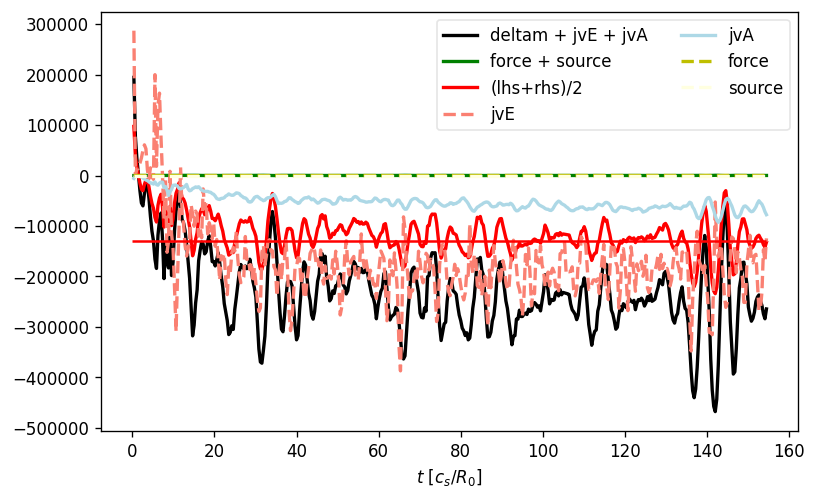

Resistivity = 3e-06
Average diff =  -9399.954705423193


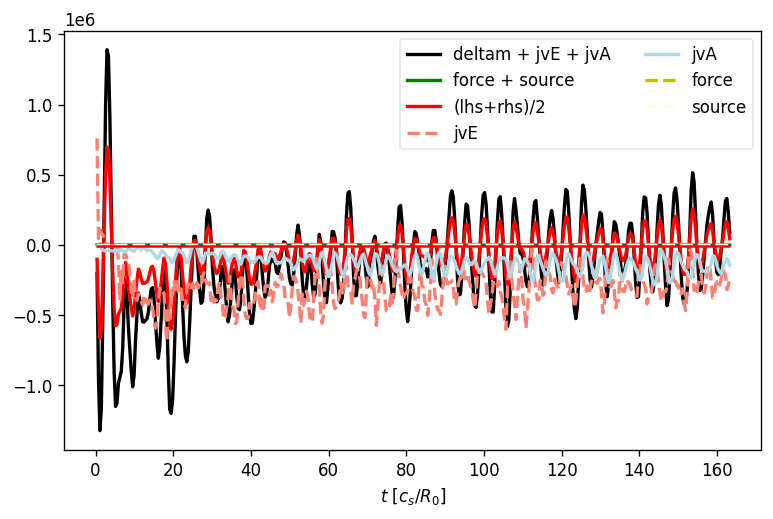

Resistivity = 1e-05
Average diff =  -148947.86881197774


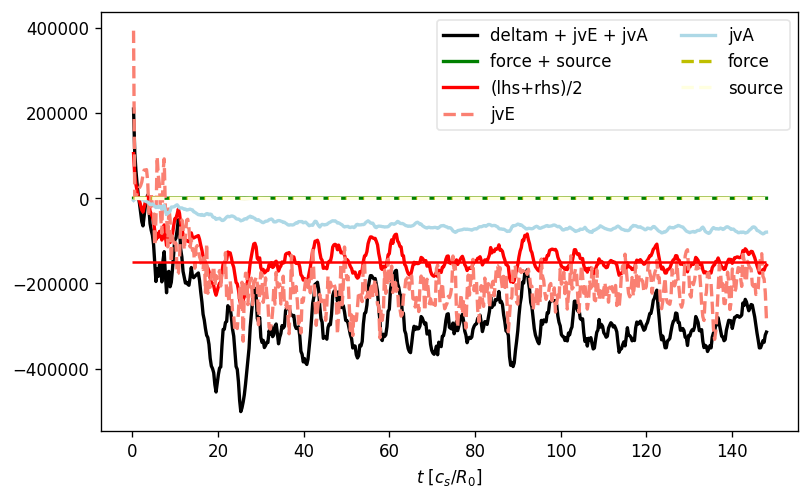

Resistivity = 1e-05
Average diff =  -131870.67403743244


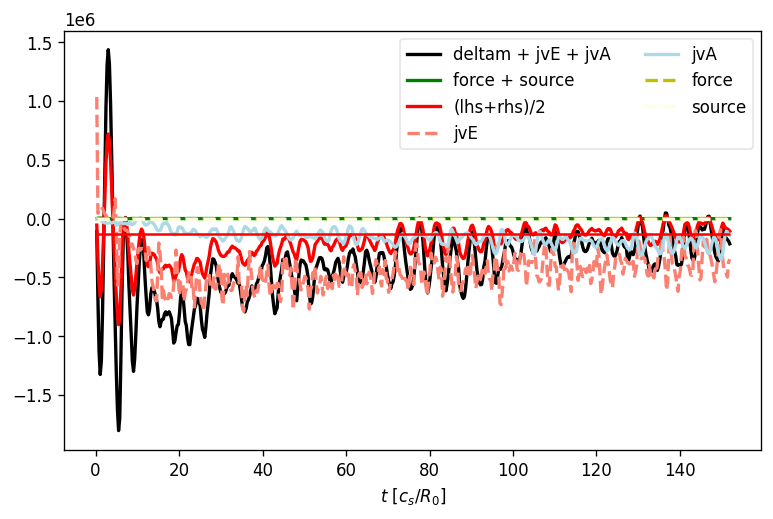

Resistivity = 3e-05
Average diff =  -187100.01634697244


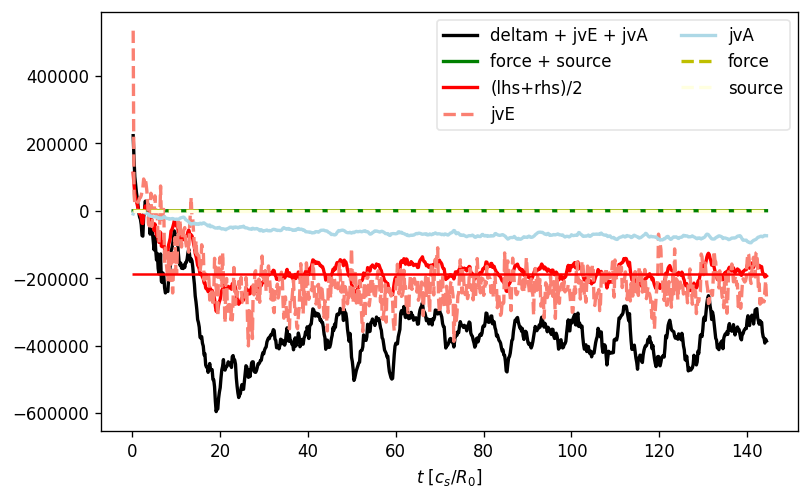

Resistivity = 3e-05
Average diff =  -340790.7832017218


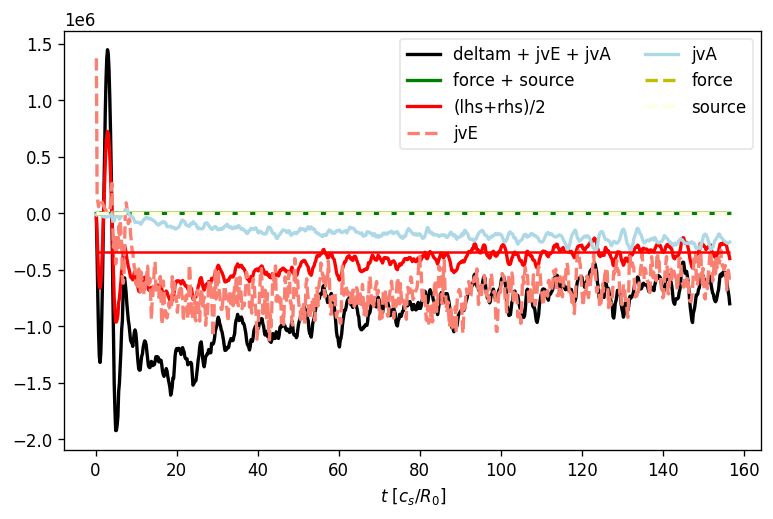

Resistivity = 0.0001
Average diff =  -296137.0420632284


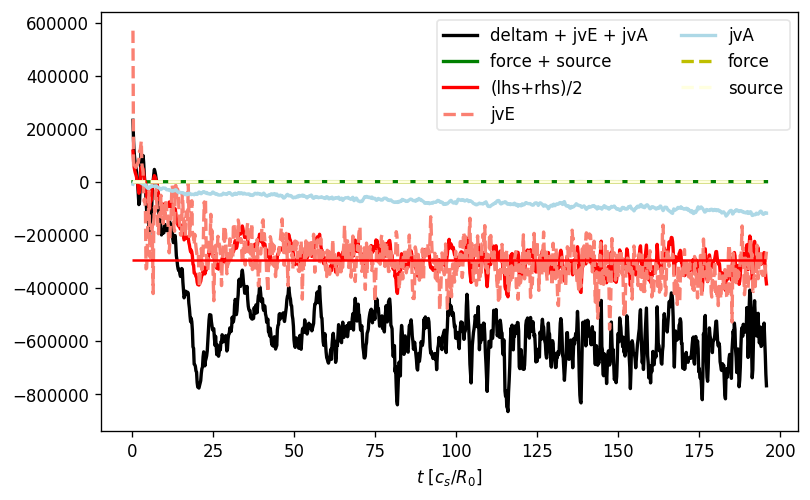

Resistivity = 0.0001
Average diff =  -1098923.01955098


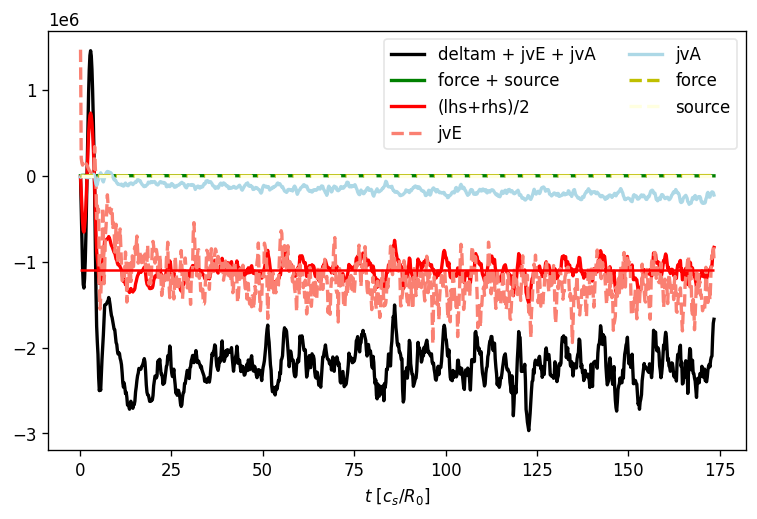

Resistivity = 0.0003
Average diff =  -338182.8685962274


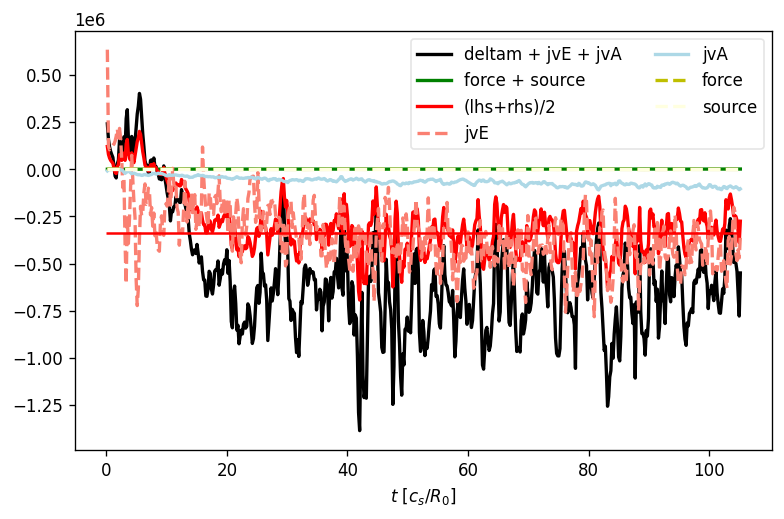

Resistivity = 0.0003
Average diff =  -1873699.9391458665


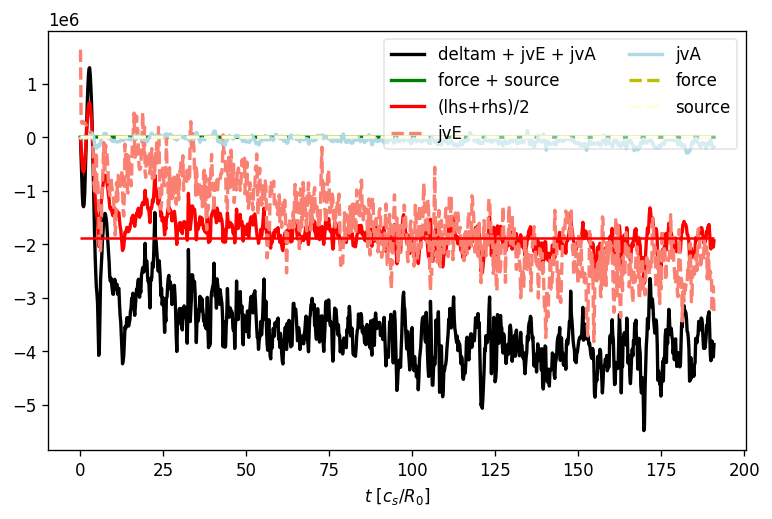

In [24]:
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
    
#     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = da.variables['time'][:]
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    
    
    mass =np.asarray(da.variables['niuibphi_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltam = np.diff(masstt,axis=0)/deltat

    source = np.asarray(da.variables['sparsnibphi_tt_ifs_lcfs'][:])/deltat
    
    jvneE = np.asarray(da['jvparbphiexbi_tt_ifs_lcfs'][:])/deltat
    jvneA = np.asarray(da['jvparbphiApar_tt_ifs_lcfs'][:])/deltat
    
    force = -np.asarray(da.variables["socurve_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(da.variables["socurvi_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(da.variables["socurvkappae_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(da.variables["socurvkappai_tt_ifs_lcfs"][:])/deltat
    lhs = deltam + jvneE + jvneA
    rhs = -force + source
    diff = (lhs - rhs)/2
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {pp["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,lhs[1:], color='k', marker='',
              ls='-', lw=2,markeredgecolor='k', markersize=8, label="deltam + jvE + jvA")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=2,markeredgecolor='g', markersize=8, label="force + source")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=2,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.plot(time[1:]*timescale,jvneE[1:], color='salmon', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="jvE")
    plt.plot(time[1:]*timescale,jvneA[1:], color='lightblue', marker='',
              ls='-', lw = 2, markeredgecolor='k', markersize=8, label="jvA")
    plt.plot(time[1:]*timescale,force[1:], color='y', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="force")
    plt.plot(time[1:]*timescale,source[1:], color='lightyellow', marker='',
              ls='--', lw = 2, markeredgecolor='k', markersize=8, label="source")
    plt.hlines(average_diff, time[0]*timescale, time[-1]*timescale, color='r')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )